# <ins>Fuel Efficiency of Canadian Vehicles<ins>
> # Econ 323 Final Project

A Project By:
| Name | Student Number | Section |
|------|----------------|---------|
| Alexander Proskiw | 27194166 | 003 |
| Kai Groden-Gilchrist | 35600148 | 003 |

# Table Of Contents

1. Introduction

2. Importing and Cleaning the Data

    2.1 Required Import Statements

    2.2 Read and Concatenate the Data

    2.3 Cleaning the Data

    2.4 Dataset Summary

3. Visualizations and Key Findings

    3.1 Effect of the Explanatory Variables on Fuel Efficiency

    3.2 Interactions Between Year and Other Explanatory Variables

    3.3 Most Efficient Vehicles and Makes

4. Modelling and Predicting Fuel Efficiency

    4.1 Models With No Interactions

    4.2 Models With Interactions With Year

    4.3 Predicting Fuel Efficiency of 2024 Vehicles

5. R&D Spending
6. Discussion
7. Conclusion and Future Opportunities

# 1. Introduction

With gasoline prices reaching record highs in 2022 and remaining elevanted since, fuel efficiency is a key concern for consumers looking to buy a vehicle. There is lots of generic advice thrown around, such as "new vehicles are so much more fuel efficient" or "SUVs are all just gas guzzlers". But what is the reality of the fuel efficiency of vehicles sold in the Canadian market? The goal of this research project is to explore fuel efficiency of Canadian vehicles by answering the following questions:
> -----
> <ins>**Key Research Questions**</ins>
>
> 1. Has vehicle fuel efficiency improved from 2000 to 2023?
>
> 2. Which manufacturer produces, on average, the most fuel efficient vehicles?
>
> 3. Can existing fuel efficiency information be used to predict the fuel efficiency of future vehicles?
>
> 4. Are changes in fuel efficiency for a manufacturer related to R&D spending?
> -----

The dataset chosen for this project is the [Natural Resources Canada Fuel Consumption Ratings Dataset](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64?fbclid=IwAR1rVpyNw3KJSeAcT6ryyCAADAnmB7uDtujvwlswFkOzaiLlnjIt29EekiY), which includes fuel consumption information for vehicles sold in Canada from 2000 to 2023, along with supporting information about each vehicle such as make, model, vehicle type, engine size, and transmission type.

# 2. Importing and Cleaning the Data

Prior to performing any visualizations or modelling, the separate fuel consumption datasets must be imported and combined. Due to the unique abbreviations used for certain columns of data as well as differences in how the data is presented between years, data cleaning is also required. The following sections are provided to achieve the importing and cleaning of the raw datasets:
- Section 2.1 imports all the libraries and packages used in this investigation.

- Section 2.2 reads in the datasets from csv files, and combines them into one pandas DataFrame.

- Section 2.3 cleans the DataFrame for future manipulation. 

- Section 2.4 gives an initial overview of the data and how it will be used.

## 2.1 Required Import Statements

First all python packages that will be utilized in this project are imported. Additionally, custom figure display and text output options are specified.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import patsy
import tabula
from plotly import express as px, graph_objs as go
from sklearn import (linear_model, metrics, tree, model_selection, neural_network, preprocessing, pipeline)
from sklearn.model_selection import cross_val_score
from itertools import cycle
from datetime import datetime
pd.set_option('display.max_rows', 100)
sns.set_palette("muted")
sns.set_style("darkgrid")
%matplotlib inline 

## 2.2 Read and Concatenate the Data

Next the csv files from the Natural Resources Canada Database are read, specifically the aggregated files for 2000-2004, 2005-2009, and 2010-2014, as well as the yearly files from 2015 to 2023.

In [2]:
fuel_cons_2023 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2023%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2022 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2022%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2021 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2021%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2020 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2020%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2019 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2019%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2018 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2018%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2017 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2017%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2016 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2016%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2015 = pd.read_csv("https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2015%20Fuel%20Consumption"
                             + "%20Ratings.csv", encoding="Windows-1252", low_memory=False)
fuel_cons_2010_2014 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2010-2014"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)
fuel_cons_2005_2009 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2005-2009"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)
fuel_cons_2000_2004 = pd.read_csv("https://www.nrcan.gc.ca/sites/www.rncan.gc.ca/files/oee/files/csv/MY2000-2004"
                             + "%20Fuel%20Consumption%20Ratings%205-cycle.csv", encoding="Windows-1252", 
                                  low_memory=False)

Next the individual datasets are combined into a single dataset. This includes removing rows with NA values, and dropping certain non-data rows at the bottom of each spreadsheet.

In [3]:
# drop nas and combine datasets from each year
list_of_fuel_data = [fuel_cons_2023, fuel_cons_2022, fuel_cons_2021, fuel_cons_2020, fuel_cons_2019,
                    fuel_cons_2018, fuel_cons_2017, fuel_cons_2016, fuel_cons_2015, fuel_cons_2010_2014,
                    fuel_cons_2005_2009, fuel_cons_2000_2004]

col_names = ["model_year", "make", "model", "vehicle_class", "engine_size_L", "cylinders", "transmission", 
             "fuel_type", "city_fuel_cons", "hwy_fuel_cons", "comb_lpkm", "comb_mpg", "co2_emissions", 
             "co2_rating","smog_rating"]

for i, dataset in enumerate(list_of_fuel_data):
    # drop rows of entirely NaN, then cols of entirely NaN, then rows with some NaN
    # there was ~50 rows at the bottom with text explaining the data, hence the need for the last drop
    dataset = dataset.dropna(axis=0, how='all').dropna(axis=1, how='all').dropna(axis=0)
    try: 
        dataset.columns = col_names
    # older datasets are missing the last one or two cols
    except ValueError:
        try: 
            dataset.columns = col_names[:-1]
        except ValueError:
            dataset.columns = col_names[:-2]
    list_of_fuel_data[i] = dataset
            
full_dataset = pd.DataFrame()

for dataset in list_of_fuel_data:
    full_dataset = pd.concat([full_dataset, dataset], axis=0)
    
full_dataset.reset_index(drop=True, inplace=True)

The original csv files contain data on the city, highway, and combined (55% city, 45% highway) fuel economy for each vehicle. For the purposes of this research project, **<ins>the combined fuel economy (in liters per 100 km, abbreviated as L/100km) is selected as the response variable</ins>** so as to get a broad representation of each vehicle's efficiency. 

Hence, after concatenating the individual datasets, the following unnecessary columns are dropped:
- City fuel economy and highway fuel economy, as the combined fuel economy represents their weighted average.

- Combined fuel economy in miles per gallon, as this is just a unit conversion from L/100km.

- CO2 emissions, CO2 rating, and Smog rating, as this research project is focusing on fuel efficiency and not emissions or smog.

In [4]:
# drop unnecessary columns
full_dataset.drop(["city_fuel_cons", "hwy_fuel_cons", "comb_mpg", "co2_emissions", "co2_rating", "smog_rating"], 
                  axis=1, inplace=True)
# preview the dataset
full_dataset

,model_year,make,model,vehicle_class,engine_size_L,cylinders,transmission,fuel_type,comb_lpkm
0,2023,Acura,Integra,Full-size,1.5,4.0,AV7,Z,7.2
1,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,AV7,Z,7.4
2,2023,Acura,Integra A-SPEC,Full-size,1.5,4.0,M6,Z,7.8
3,2023,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS10,Z,11.2
4,2023,Acura,MDX SH-AWD Type S,SUV: Standard,3.0,6.0,AS10,Z,12.4
...,...,...,...,...,...,...,...,...,...
23477,2004,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,AS5,Z,12.5
23478,2004,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,M5,Z,11.8
23479,2004,VOLVO,XC70 AWD TURBO,SUV,2.5,5.0,AS5,Z,12.5
23480,2004,VOLVO,XC90 2.5T AWD TURBO,SUV,2.5,5.0,AS5,Z,13.0


The above output provides the first look at the datset for this project.

It is immediately noted that several of the rows have somewhat confusing information. For example, fuel type is represented as a letter, transmission is an abbreviation, and vehicle class appears inconsistent with 3 different labelings for SUVs present in just the first 5 and last 5 rows of the dataset alone.

All of these issues need to be addressed through cleaning of the data.

## 2.3 Cleaning the Data

First the datatypes for each column are determined:

In [5]:
full_dataset.dtypes

model_year        object
make              object
model             object
vehicle_class     object
engine_size_L     object
cylinders        float64
transmission      object
fuel_type         object
comb_lpkm         object
dtype: object

Aside from cylinders, all datatypes are currently of type "object". Certain columns need to be converted to numeric data, namely integers for the year and floats for the engine size and fuel efficiency.

In [6]:
# convert appropriate object datatypes to numerical
full_dataset["model_year"] = full_dataset["model_year"].astype(int)
cols = ["engine_size_L", "comb_lpkm"]
full_dataset[cols] = full_dataset[cols].astype(float)
full_dataset.dtypes

model_year         int32
make              object
model             object
vehicle_class     object
engine_size_L    float64
cylinders        float64
transmission      object
fuel_type         object
comb_lpkm        float64
dtype: object

Next the vehicle 'make' column needs to be cleaned. This column represents the manufacturer of a particular vehicle.

Minor improvements include fixing inconsistent capitalization, and combining "Ram" and "Dodge" into a single brand.

More importantly, rows are removed for any manufacturer that didn't produce at least one vehicle in every year from 2000 to 2023. This step is implemented because the project aims to assess fuel efficiency changes over the entire 2000 to 2023 time period. A manufacturer could potentially skew the results if they went bankrupt in the early 2000's, or didn't start producing cars until the late 2010's.

In [7]:
# clean the 'make' series

# different capitalizations of makes were used in different years. Update for consistency.
full_dataset["make"] = full_dataset["make"].str.title()

# also adjust to account for Dodge rebranding their pickup trucks under the Ram name
full_dataset["make"].replace({"Ram": "Dodge"}, inplace = True)

# remove data from the datset for manufacturers that didn't make cars from 2000 to 2023
makes = full_dataset.groupby("make")
for make in makes.groups:
    matches_make = (full_dataset["make"] == make)
    only_current_make_dataset = full_dataset[matches_make]
    num_years = only_current_make_dataset["model_year"].nunique()
    not_full_range_of_years = (num_years != 24)
    if not_full_range_of_years:
        full_dataset.drop(only_current_make_dataset.index, inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

# verify changes
print(full_dataset["make"].unique())

['Acura' 'Audi' 'Bmw' 'Buick' 'Cadillac' 'Chevrolet' 'Chrysler' 'Dodge'
 'Ford' 'Gmc' 'Honda' 'Hyundai' 'Infiniti' 'Jaguar' 'Jeep' 'Kia' 'Lexus'
 'Lincoln' 'Mazda' 'Mercedes-Benz' 'Nissan' 'Subaru' 'Toyota' 'Volkswagen'
 'Volvo']


Upon cleaning the vehicle 'make' column, it is verified that the dataset now contains 25 unique vehicle manufacturers from around the globe. These companies all produced vehicles every year from 2000 to 2023.

Next is to clean the 'vehicle_class' column. This column represents the broad category that a vehicle belongs to, such as whether a vehicle is a car or SUV.

The dataset initially contains many different categories, some of which are duplicates with inconsistent capitalization.

For simplicity, the various sub-categories are reduced into 4 broad categories:
- Car

- SUV

- Truck

- Van

Passenger/cargo vans were removed from the dataset at this stage, as they are often used as business vehicles (e.g., as an Amazon delivery van) rather than by typical consumers.

In [8]:
# clean the 'vehicle_class' series

# simplify into 5 categories: Car, SUV, Van, Truck, and Passenger/Cargo Van
full_dataset["vehicle_class"].replace({"Full-size": "Car",
                                       "SUV: Small": "SUV",
                                       "SUV: Standard": "SUV",
                                       "Compact": "Car",
                                       "Subcompact": "Car",
                                       "Station wagon: Small": "Car",
                                       "Mid-size": "Car",
                                       "Station wagon: Mid-size": "Car",
                                       "Two-seater": "Car",
                                       "Pickup truck: Standard": "Truck",
                                       "Minivan": "Van",
                                       "Pickup truck: Small": "Truck",
                                       "Special purpose vehicle": "Passenger/Cargo Van",
                                       "Minicompact": "Car",
                                       "Van: Passenger": "Passenger/Cargo Van",
                                       "COMPACT": "Car",
                                       "SUV - SMALL": "SUV",
                                       "TWO-SEATER": "Car",
                                       "MID-SIZE": "Car",
                                       "SUBCOMPACT": "Car",
                                       "STATION WAGON - SMALL": "Car",
                                       "FULL-SIZE": "Car",
                                       "SUV - STANDARD": "SUV",
                                       "SPECIAL PURPOSE VEHICLE": "Van",
                                       "PICKUP TRUCK - SMALL": "Truck",
                                       "VAN - PASSENGER": "Passenger/Cargo Van",
                                       "PICKUP TRUCK - STANDARD": "Truck",
                                       "MINIVAN": "Van",
                                       "STATION WAGON - MID-SIZE": "Car",
                                       "MINICOMPACT": "Car",
                                       "SUV": "SUV",
                                       "VAN - CARGO": "Passenger/Cargo Van",
                                       "UL": "SUV"}, inplace = True)

# remove the passenger/cargo van category as these are typically business vehicles
is_passenger_cargo_van = full_dataset["vehicle_class"] == "Passenger/Cargo Van"
only_passenger_cargo_van_dataset = full_dataset[is_passenger_cargo_van]
full_dataset.drop(only_passenger_cargo_van_dataset.index, inplace=True)
full_dataset.reset_index(drop=True, inplace=True)

# verify changes
print(full_dataset["vehicle_class"].unique())

['Car' 'SUV' 'Truck' 'Van']


Next is to clean the 'fuel_type' column. Using the information from [Natural Resource Canada](https://natural-resources.canada.ca/energy-efficiency/transportation-alternative-fuels/personal-vehicles/choosing-right-vehicle/buying-electric-vehicle/understanding-the-tables/21383), the single letter codes are mapped to their corresponding 5 different fuel types:
- Regular Gasoline

- Premium Gasoline

- Diesel

- Ethanol

- Natural Gas

In [9]:
# clean the 'fuel_type' series

# update the fuel types from letters to their actual meanings
full_dataset["fuel_type"].replace({"X": "Regular Gasoline",
                                   "Z": "Premium Gasoline",
                                   "D": "Diesel",
                                   "E": "Ethanol",
                                   "N": "Natural Gas"}, inplace = True)

# verify changes
print(full_dataset["fuel_type"].unique())

['Premium Gasoline' 'Regular Gasoline' 'Diesel' 'Ethanol' 'Natural Gas']


Next is to clean the 'transmission' column. This is achieved by separating the alphanumeric abbreviation into two separate columns - one for the transmission type and one for the number of gears. Transmission types include:
- Automatic

- Automated Manual

- Automatic Select Shift

- Continuously Variable

- Manual

Note that for the number of gears, Continuously Variable transmissions have been assigned as having 1 gear.

In [10]:
# clean the 'transmission' series

# separate each into the transmission type and gears
def convert_transmission_to_type(s):
    transmission_type = re.findall('([A-Za-z]+)', s)
    return transmission_type[0]

def convert_transmission_to_gears(s):
    transmission_gears = re.findall('\d+', s)
    if (transmission_gears == []):
        transmission_gears = [1]  
    return transmission_gears[0]

# separate the transmission column into separate columns for transmission type and gears, remove original column
full_dataset["transmission_type"] = full_dataset["transmission"].apply(convert_transmission_to_type)
full_dataset["transmission_gears"] = full_dataset["transmission"].apply(convert_transmission_to_gears)
full_dataset["transmission_gears"] = full_dataset["transmission_gears"].astype(int)
full_dataset.drop(["transmission"], axis=1, inplace=True)

# update the transmission types from abbreviations to their actual meanings
full_dataset["transmission_type"].replace({"A": "Automatic",
                                           "AM": "Automated Manual",
                                           "AS": "Automatic Select Shift",
                                           "AV": "Continuously Variable",
                                           "M": "Manual",}, inplace = True)

# verify changes
full_dataset

,model_year,make,model,vehicle_class,engine_size_L,cylinders,fuel_type,comb_lpkm,transmission_type,transmission_gears
0,2023,Acura,Integra,Car,1.5,4.0,Premium Gasoline,7.2,Continuously Variable,7
1,2023,Acura,Integra A-SPEC,Car,1.5,4.0,Premium Gasoline,7.4,Continuously Variable,7
2,2023,Acura,Integra A-SPEC,Car,1.5,4.0,Premium Gasoline,7.8,Manual,6
3,2023,Acura,MDX SH-AWD,SUV,3.5,6.0,Premium Gasoline,11.2,Automatic Select Shift,10
4,2023,Acura,MDX SH-AWD Type S,SUV,3.0,6.0,Premium Gasoline,12.4,Automatic Select Shift,10
...,...,...,...,...,...,...,...,...,...,...
18933,2004,Volvo,V70 T5 TURBO,Car,2.3,5.0,Premium Gasoline,12.5,Automatic Select Shift,5
18934,2004,Volvo,V70 T5 TURBO,Car,2.3,5.0,Premium Gasoline,11.8,Manual,5
18935,2004,Volvo,XC70 AWD TURBO,SUV,2.5,5.0,Premium Gasoline,12.5,Automatic Select Shift,5
18936,2004,Volvo,XC90 2.5T AWD TURBO,SUV,2.5,5.0,Premium Gasoline,13.0,Automatic Select Shift,5


Having successfully cleaned all the data columns, they are reordered intuitively.

In [11]:
# reorder the columns
full_dataset = full_dataset[["model_year", "make", "model", "vehicle_class", "fuel_type",
                             "engine_size_L", "cylinders", "transmission_type", 
                             "transmission_gears", "comb_lpkm"]]

# verify changes
full_dataset

,model_year,make,model,vehicle_class,fuel_type,engine_size_L,cylinders,transmission_type,transmission_gears,comb_lpkm
0,2023,Acura,Integra,Car,Premium Gasoline,1.5,4.0,Continuously Variable,7,7.2
1,2023,Acura,Integra A-SPEC,Car,Premium Gasoline,1.5,4.0,Continuously Variable,7,7.4
2,2023,Acura,Integra A-SPEC,Car,Premium Gasoline,1.5,4.0,Manual,6,7.8
3,2023,Acura,MDX SH-AWD,SUV,Premium Gasoline,3.5,6.0,Automatic Select Shift,10,11.2
4,2023,Acura,MDX SH-AWD Type S,SUV,Premium Gasoline,3.0,6.0,Automatic Select Shift,10,12.4
...,...,...,...,...,...,...,...,...,...,...
18933,2004,Volvo,V70 T5 TURBO,Car,Premium Gasoline,2.3,5.0,Automatic Select Shift,5,12.5
18934,2004,Volvo,V70 T5 TURBO,Car,Premium Gasoline,2.3,5.0,Manual,5,11.8
18935,2004,Volvo,XC70 AWD TURBO,SUV,Premium Gasoline,2.5,5.0,Automatic Select Shift,5,12.5
18936,2004,Volvo,XC90 2.5T AWD TURBO,SUV,Premium Gasoline,2.5,5.0,Automatic Select Shift,5,13.0


## 2.4 Dataset Summary

The cleaned dataset has 18,938 unique entries, each representing a specific vehicle. The columns represent different variables, broken down as follows:

<ins>Response Variable:</ins>
- The "comb_lpkm" column represents the combined fuel efficiency of each vehicle in liters per 100 kilometers (L/100km). This is a continuous numerical variable.

> -----
> <ins>**Important Note**</ins>
>
> When using L/100km, a smaller number represents a more efficient vehicle. 
>
> This is the opposite of miles per gallon, where higher numbers are more efficient.
>
> -----

<ins>Explanatory Variables:</ins>
- The "model_year" column represents the year a vehicle was produced in. This is a continuous numerical variable.

- The "make" column represents the manufacturer of a vehicle. A total of 25 different manufacturers are included in the dataset. This is a categorical variable.

- The "vehicle_class" column represents whether a vehicle is a car, truck, SUV, or van. This is a categorical variable.

- The "fuel_type" column represents what type of fuel a vehicle uses. This is a categorical variable.

- The "engine_size_L" column represents the size of the engine of a vehicle, in liters. This is a continuous numerical variable.

- The "cylinders" column represents the number of cylinders of the engine of a vehicle. This is a continuous numerical variable.

- The "transmission_type" column represents the type of transmission of a vehicle. This is a categorical variable.

- The "transmission_gears" column represents the number of gears in the transmission of a vehicle. This is a continuous numerical variable.

<ins>Additional Variable:</ins>
- The "model" column includes the specific name of each vehicle. This column will not be used in any visualization or modelling, but is helpful when determining the most/least efficient vehicles.

# 3. Visualizations and Key Findings

This section presents a set of visualizations aimed at gaining a deeper understanding of vehicle fuel efficiency.

Section 3.1 examines the relationship between fuel economy and each of the explanatory variables in isolation (year, make, vehicle class, fuel type, engine size, cylinders, transmission type, and transmission gears).

Section 3.2 explores how the year of a vehicle interacts with some of the other explanatory variables.

Section 3.3 takes a closer look at the most efficient vehicles and makes.

## 3.1 Effect of the Explanatory Variables on Fuel Efficiency

### 3.1.1 Model Year

To examine how fuel efficiency varies by year, data is aggreggated across all the vehicles for each year. Three metrics for each year are plotted: an average fuel efficiency, along with the 5th and 95th percentiles (representing a 90% confidence interval).

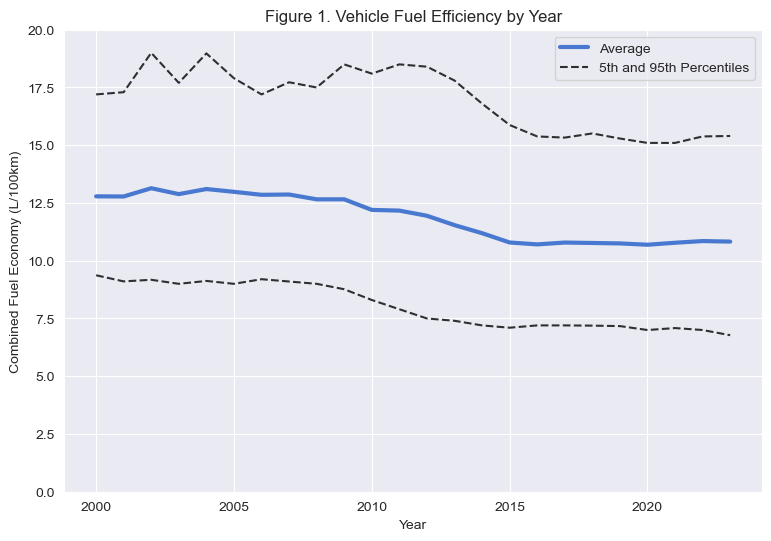

In [12]:
# 5th Percentile
def q05(x):
    return x.quantile(0.05)

# 95th Percentile
def q95(x):
    return x.quantile(0.95)


fuel_economy_by_year = full_dataset.pivot_table(index="model_year", 
                                                values="comb_lpkm", 
                                                aggfunc=["mean", q05, q95])
ax = fuel_economy_by_year.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_title("Figure 1. Vehicle Fuel Efficiency by Year")
ax.set_ylim(0, 20)
plt.gca().get_lines()[0].set_linewidth(3)
plt.gca().get_lines()[1].set_color("black")
plt.gca().get_lines()[1].set_linestyle("--")
plt.gca().get_lines()[1].set_alpha(0.8)
plt.gca().get_lines()[2].set_color("black")
plt.gca().get_lines()[2].set_linestyle("--")
plt.gca().get_lines()[2].set_alpha(0.8)
ax.legend(['Average', '5th and 95th Percentiles'])
plt.gcf().set_size_inches(9, 6)

The figure above clearly demonstrates a downward trend in the combined fuel economy of vehicles from 2000 to 2023. 

The average fuel economy across all makes and models decreased from approximately 12.8 L/100km in 2000 to 10.8 L/100km in 2023 (approximately 16%). Decreases were also observed for the 5th and 95th percentiles of vehicles. 

However, the improvements in fuel economy do not appear to be uniform. Little change is observed from 2000 to 2010, followed by a large improvement in fuel economy from 2010 to 2015. Since 2015, we observe little change.

While newer cars generally appear to be more fuel-efficient than older models, it will likely be beneficial to analyze each manufacturer individually.

### 3.1.2 Make

To examine how fuel efficiency varies by make, data is aggregated across all the vehicles and years for each make. 

This equates to an average fuel efficiency value for all the vehicles each manufacturer has produced from 2000 to 2023.

A figure showing this average fuel economy for each manufacturer is provided below, ordered from most to least efficicent.

Text(0.5, 1.0, 'Figure 2. Fuel Economy by Different Manufacturers, Averaged Across all Years')

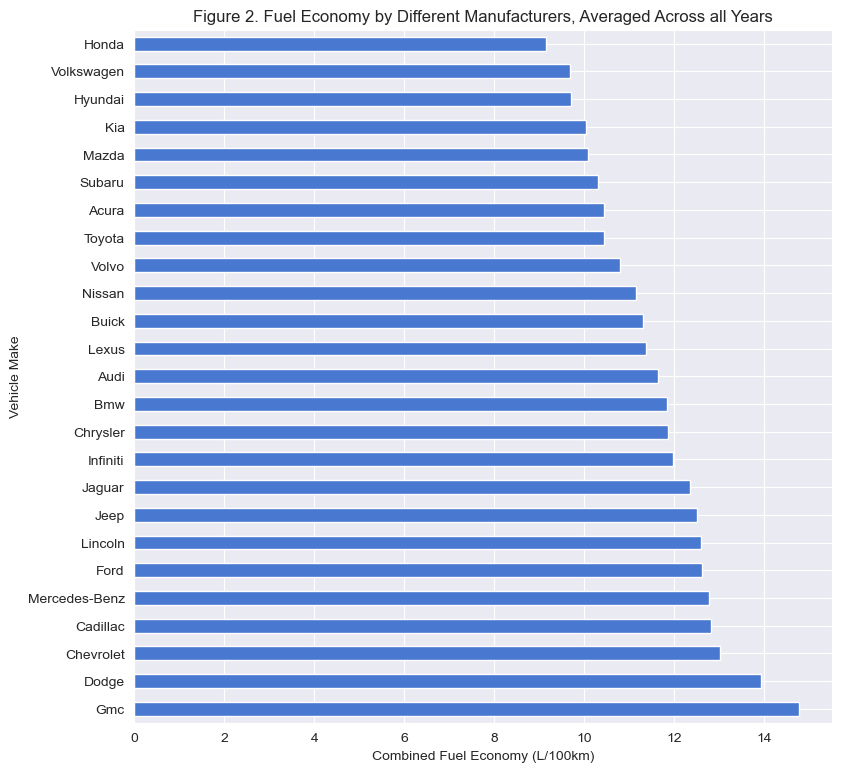

In [13]:
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", 
                                                         columns="make", 
                                                         values="comb_lpkm", 
                                                         aggfunc="mean")

ax = fuel_economy_by_year_and_make.mean().sort_values(ascending=False).plot(kind="barh", figsize=(9, 9))
ax.set_ylabel("Vehicle Make")
ax.set_xlabel("Combined Fuel Economy (L/100km)")
ax.set_title("Figure 2. Fuel Economy by Different Manufacturers, Averaged Across all Years")

The figure above shows the average combined fuel economy for each manufacturer included in this investigation. On average, Honda vehicles are the most efficient (average of 9.2 L/100km) while GMC vehicles are the least efficient (average of 14.8 L/100km). These results will be unsurprising to most, since Honda primarily manufactures cars while GMC specializes in trucks and SUVs. 

It's evident then, that the vehicle type may play an important role in determining fuel economy. 

### 3.1.3 Vehicle Type

To assess the effect of vehicle type a boxplot visualization is utilized. Each box represents all the vehicles of that type in the dataset (across all years, makes, etc.)

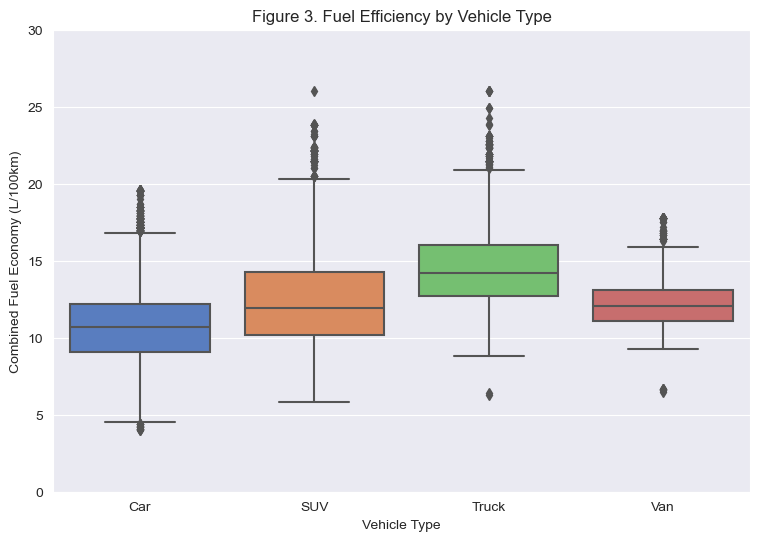

In [14]:
# fuel efficiency by vehicle type
ax = sns.boxplot(data=full_dataset, x="vehicle_class", y="comb_lpkm")
ax.set(xlabel="Vehicle Type", ylabel="Combined Fuel Economy (L/100km)", title="Figure 3. Fuel Efficiency by Vehicle Type")
ax.set_ylim(0, 30)
plt.gcf().set_size_inches(9, 6)

The figure above presents the average combined fuel economy for each vehicle class that was examined. It is evident that cars have the lowest average fuel economy, while SUVs and vans have similar means (although SUVs exhibit a greater degree of variation around it), and trucks have the highest average fuel economy.

### 3.1.4 Fuel Type

Similar to assessing vehicle types, a boxplot is utilized to view the differences between the distributions of each fuel type. Each box represents all the vehicles of that fuel type in the dataset (across all years, makes, etc.)

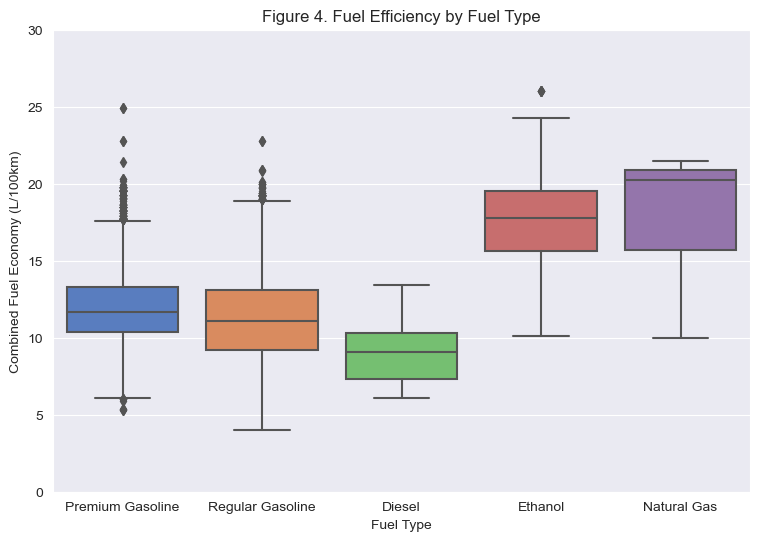

In [15]:
# fuel efficiency by fuel type
ax = sns.boxplot(data=full_dataset, x="fuel_type", y="comb_lpkm")
ax.set(xlabel="Fuel Type", ylabel="Combined Fuel Economy (L/100km)", title="Figure 4. Fuel Efficiency by Fuel Type")
ax.set_ylim(0, 30)
plt.gcf().set_size_inches(9, 6)

In [16]:
# how many of each number of fuel types?
full_dataset["fuel_type"].value_counts()

Regular Gasoline    10610
Premium Gasoline     7024
Ethanol               909
Diesel                377
Natural Gas            18
Name: fuel_type, dtype: int64

The figure above illustrates the combined fuel efficiency of different engine types. While the average is lowest for diesel vehicles, the lower range of both premium and regular gasoline vehicles appear more efficient than any observed diesel vehicle. That said, the upper range for both gasoline vehicles are far less efficient than any observed diesel vehicle. Ethanol and natural gas powered vehicles are evidently the least efficient in this dataset. However, natural gas has a relatively small sample size of only 18 observations, so it may be subject to sampling bias.

### 3.1.5 Engine Size

The scatter plot below is used to compare the engine size and fuel economy of each vehicle.

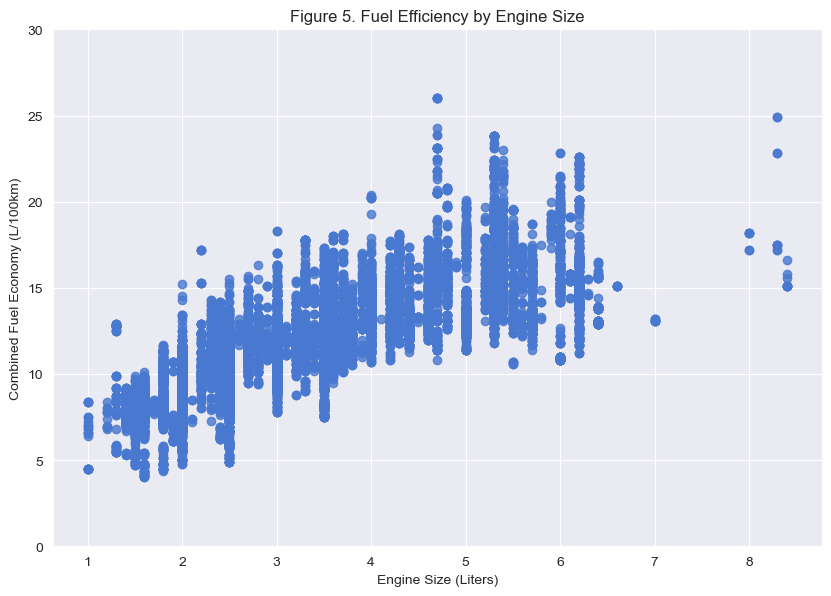

In [17]:
# fuel efficiency by engine size
ax = sns.lmplot(data=full_dataset, x="engine_size_L", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Engine Size (Liters)", ylabel="Combined Fuel Economy (L/100km)", 
       title="Figure 5. Fuel Efficiency by Engine Size")
ax.set(ylim=(0, 30))
plt.gcf().set_size_inches(9, 6)

The figure above shows a positive correlation between engine size and combined fuel economy. In simpler terms, it indicates that vehicles equipped with larger engines tend to be less fuel-efficient. 

### 3.1.6 Effect of Engine Cylinders

The scatter plot below is used to compare the number of engine cylinders and fuel economy of each vehicle.

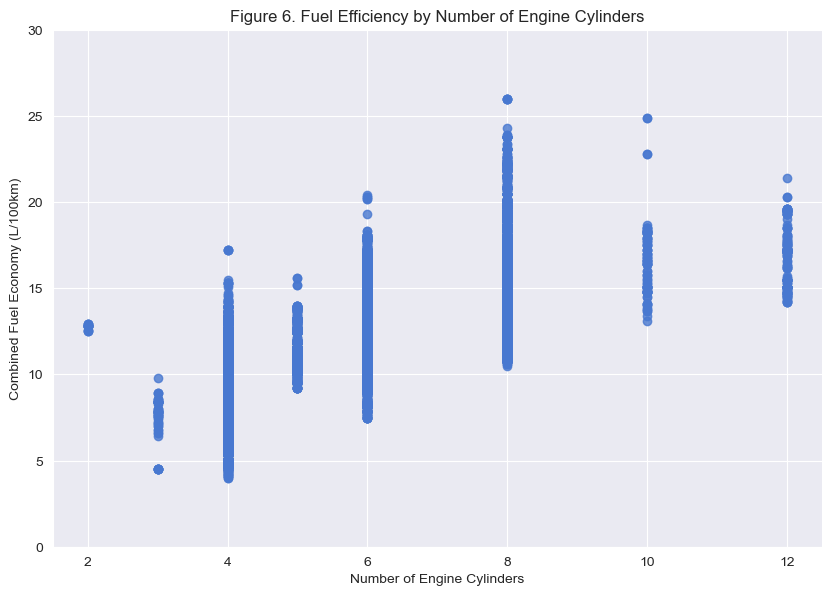

In [18]:
# fuel efficiency by engine cylinders
ax = sns.lmplot(data=full_dataset, x="cylinders", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Number of Engine Cylinders", ylabel="Combined Fuel Economy (L/100km)", 
       title="Figure 6. Fuel Efficiency by Number of Engine Cylinders")
ax.set(ylim=(0, 30))
ax.fig.set_size_inches(9, 6)

In [19]:
# how many of each number of engine cylinders?
full_dataset["cylinders"].value_counts()

4.0     6942
6.0     6779
8.0     4410
5.0      483
12.0     149
10.0     100
3.0       59
2.0       16
Name: cylinders, dtype: int64

The figure above indicates a positive correlation between the number of engine cylinders and combined fuel economy for vehicles with more than 3 cylinders. Vehicles with 2 cylinders exhibit a higher than expected combined fuel economy; however, with a relatively small sample size of only 16 observations, it may be subject to sampling bias.

### 3.1.7 Transmission Type

A boxplot is utilized to view the differences between the distributions of each transmission type. Each box represents all the vehicles of that transmission type in the dataset (across all years, makes, etc.).

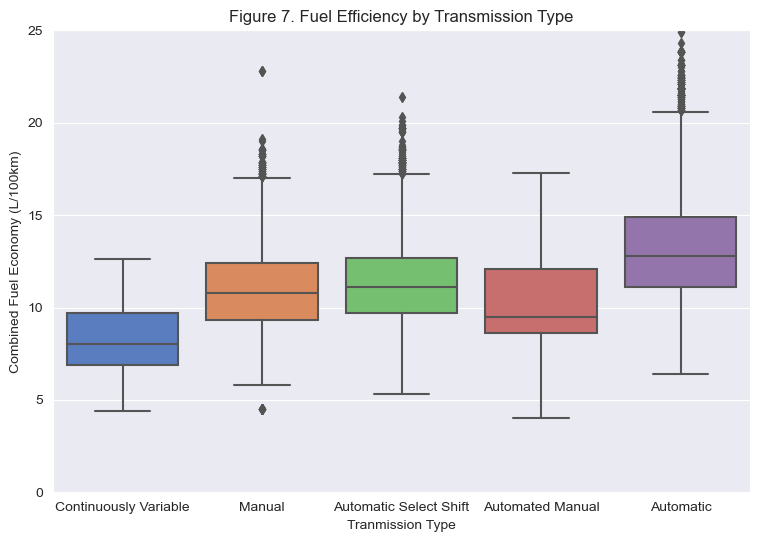

In [20]:
# fuel efficiency by transmission type
ax = sns.boxplot(data=full_dataset, x="transmission_type", y="comb_lpkm")
ax.set(xlabel="Tranmission Type", ylabel="Combined Fuel Economy (L/100km)", 
       title="Figure 7. Fuel Efficiency by Transmission Type")
ax.set(ylim=(0, 25))
plt.gcf().set_size_inches(9, 6)

This figure shows the combined fuel economy for each transmission type. Continuously variable transmissions appear to be the most fuel-efficient, while automatic transmission appear to be the least efficient. Continuously variable transmissions also appear to have the smallest variability in fuel economy.

### 3.1.8 Number of Transmission Gears

The final variable is the number of transmission gears, and it's relationship with fuel economy is represented as a scatter plot.

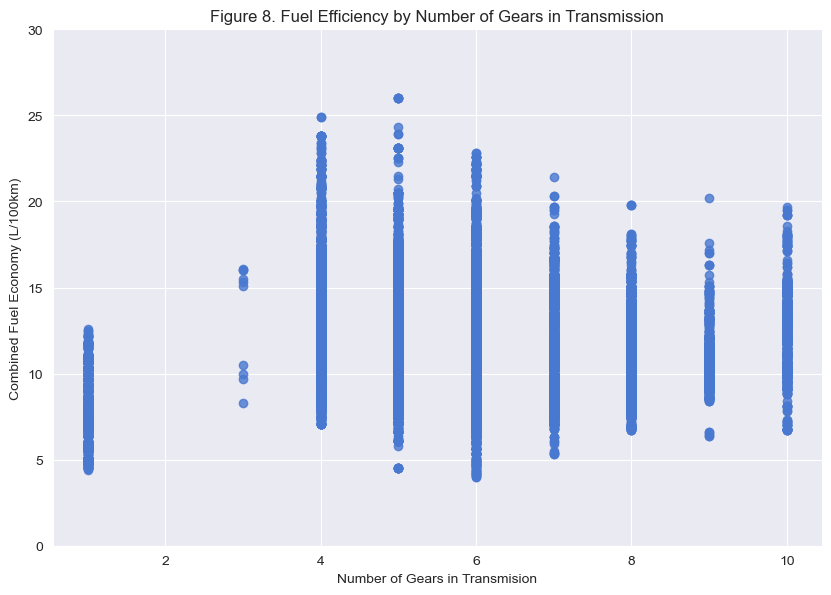

In [21]:
# fuel efficiency by transmission gears
ax = sns.lmplot(data=full_dataset, x="transmission_gears", y="comb_lpkm", fit_reg=False)
ax.set(xlabel="Number of Gears in Transmision", ylabel="Combined Fuel Economy (L/100km)", 
       title="Figure 8. Fuel Efficiency by Number of Gears in Transmission")
ax.set(ylim=(0, 30))
plt.gcf().set_size_inches(9, 6)

The figure above shows that the number of gears in transmission appears generally uncorrelated with the combined fuel economy. The one exception is transmissions with 1 gear, which are continuously variable transmissions.

## 3.2 Interactions Between Year and Other Explanatory Variables

The previous section focused on exploring how each individual explanatory variable influences fuel efficiency. However, it was observed that the average fuel efficiency has improved from 2000 to 2023, which begs the question - is there an interaction between the year and some of the other factors?

This section will examine interactions between:
- Year and Make

- Year and Vehicle Type

- Year and Fuel Type

- Year and Transmission Type

### 3.2.1 Interaction between Year and Make

One rationale for exploring the relationship between year and make is that certain manufacturers may have improved their average fuel efficiency more than a different manufacturer over the 2000 to 2023 time period.

To assess this, fuel efficiency data is averaged for vehicles by year and make. The resulting figure is shown below.

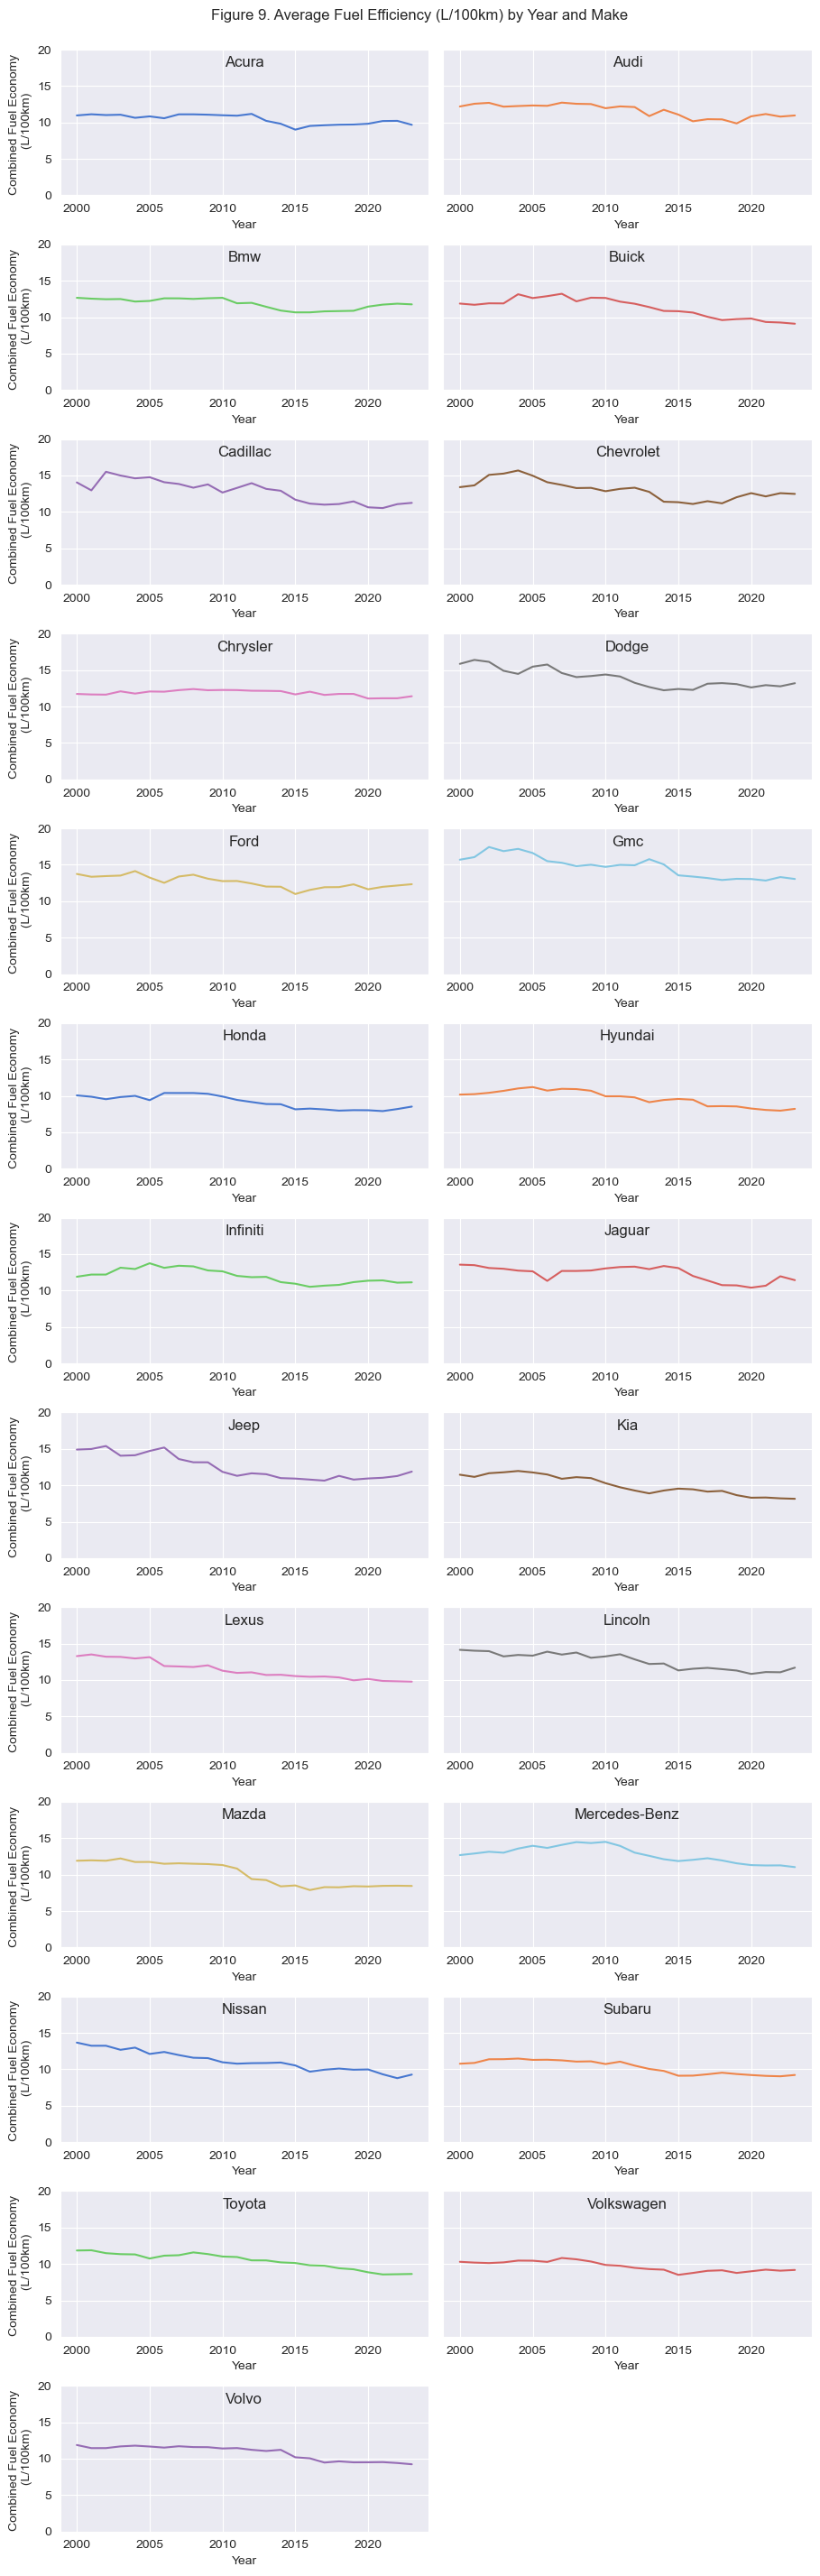

In [22]:
# exploring interaction between year and make
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", 
                                                         columns="make", 
                                                         values="comb_lpkm", 
                                                         aggfunc="mean")

axs = fuel_economy_by_year_and_make.plot.line(
    figsize=(9, 30), subplots=True, legend=False, sharex=False,
    sharey=True, layout=(13, 2), xlabel="Year"
)

axs[0,0].get_figure().tight_layout(rect=[0, 0.03, 1, 0.97])
axs[0,0].get_figure().suptitle('Figure 9. Average Fuel Efficiency (L/100km) by Year and Make')
axs = axs.ravel()
titles = fuel_economy_by_year_and_make.columns
i = 0
for ax in axs[:-1]:
    title = titles[i]
    ax.set_title(title, y=1.0, pad=-14)
    ax.set_ylim(0, 20)
    ax.set_ylabel("Combined Fuel Economy \n (L/100km)")
    i += 1

From the figure above, there are a few interesting observations.

First, fuel efficiency did not improve in every single year for all manufacturers. For example, Chevrolet, Hyundai, and Infiniti saw their average fuel efficiency get worse from 2000 to 2005.

Second, every manufacturer improved their average fuel efficiency from 2000 to 2023. However, it is apparent that there is variation in how much each manufacturer has improved. For example, it appears that Acura and Subaru have made minimal improvements in average fuel efficiency from 2000 to 2023 (although they both started with relatively low averages). In contrast, Mazda and Toyota have made much larger improvements in average fuel efficiency from 2000 to 2023.

To refine this analysis, companies are grouped based on whether their fuel efficiency between 2000 and 2023 improved by <15%, between 15% to 20%, or >20%.

Text(0.5, 0, 'Year')

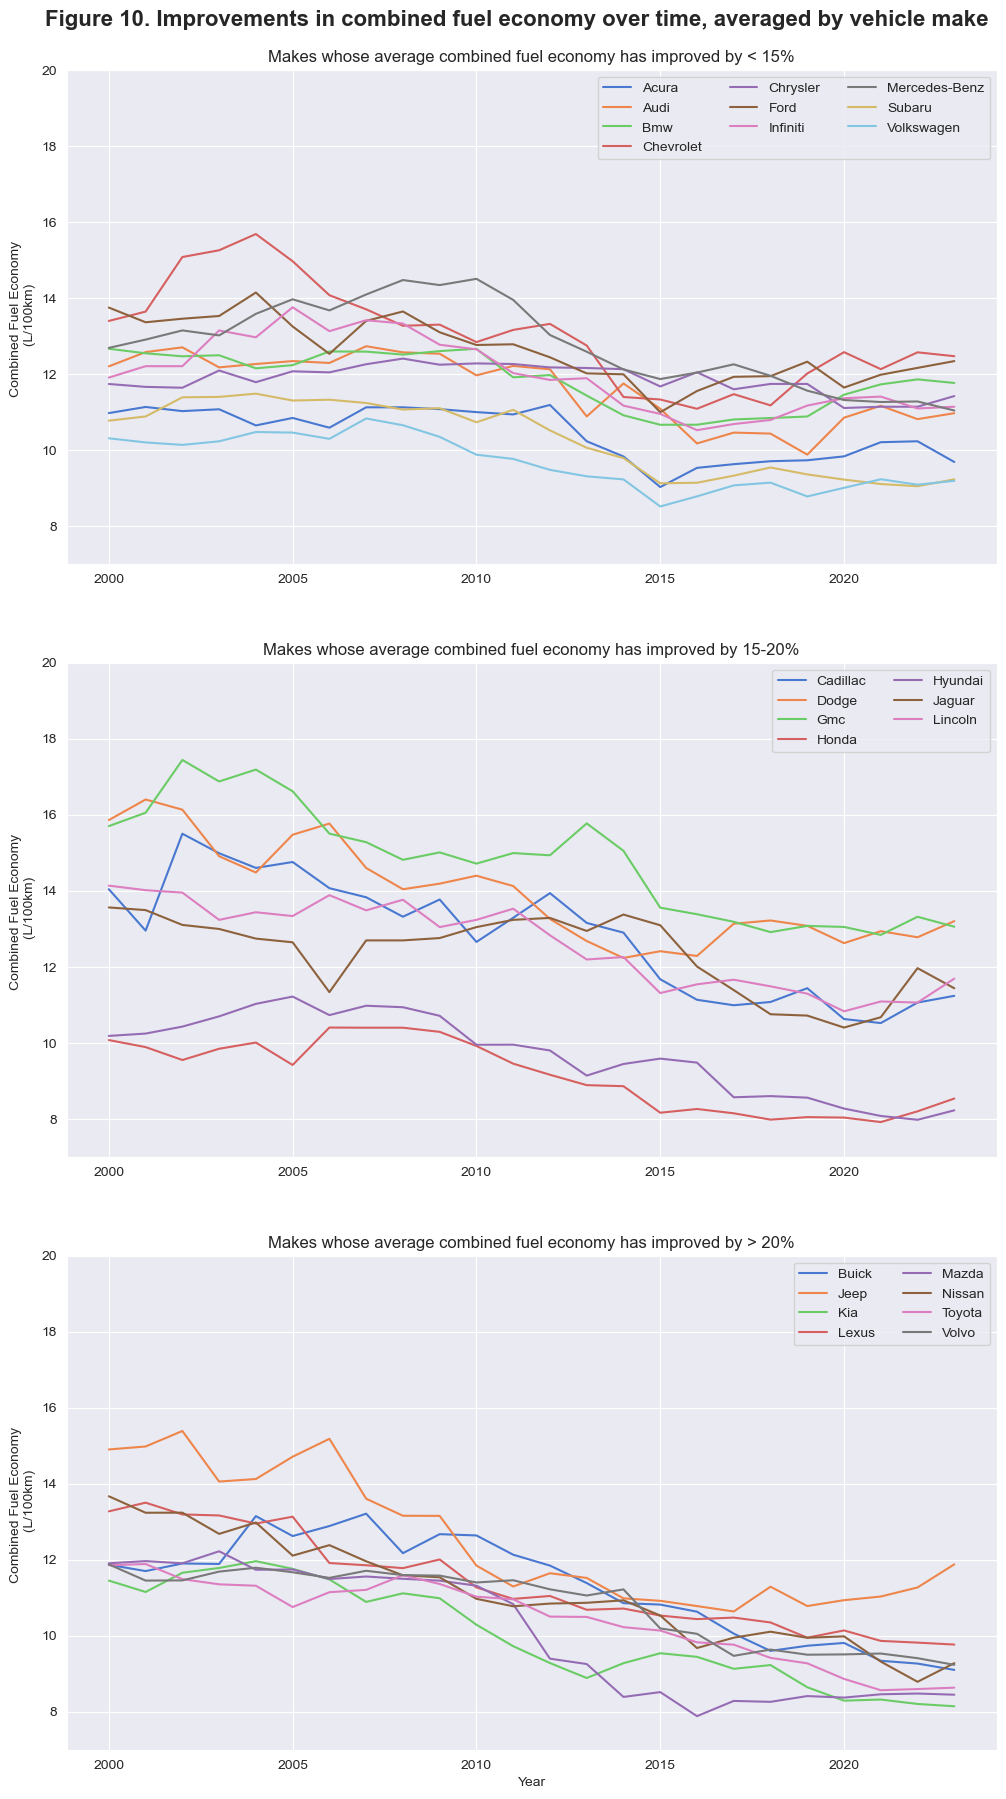

In [23]:
fuel_economy_by_year_and_make = full_dataset.pivot_table(index="model_year", 
                                                         columns="make", 
                                                         values="comb_lpkm", 
                                                         aggfunc="mean")

# separate dataset into makes which have decreased combined fuel economy by >= 15%, 20% and those who haven't
ratio = (fuel_economy_by_year_and_make.loc[2023] / fuel_economy_by_year_and_make.loc[2000])
flats = fuel_economy_by_year_and_make.loc[:, ratio >= 0.85]
mids = fuel_economy_by_year_and_make.loc[:, (ratio >= 0.8) & (ratio < 0.85)]
declining = fuel_economy_by_year_and_make.loc[:, ratio < 0.8]

fig, ax = plt.subplots(3, figsize=(12, 20))
fig.suptitle("Figure 10. Improvements in combined fuel economy over time, averaged by vehicle make", 
            fontsize=16, fontweight='bold')
fig.subplots_adjust(top=0.95)
ax[0].plot(flats)
ax[0].set_ylim(7,20)
ax[0].legend(labels=flats.columns, loc='upper right', ncol=3)
ax[0].set_title('Makes whose average combined fuel economy has improved by < 15%')
ax[0].set_ylabel("Combined Fuel Economy \n (L/100km)")
ax[1].plot(mids)
ax[1].set_ylim(7,20)
ax[1].legend(labels=mids.columns, loc='upper right', ncol=2)
ax[1].set_title('Makes whose average combined fuel economy has improved by 15-20%')
ax[1].set_ylabel("Combined Fuel Economy \n (L/100km)")
ax[2].plot(declining)
ax[2].set_ylim(7,20)
ax[2].legend(labels=declining.columns, loc='upper right', ncol=2)
ax[2].set_title('Makes whose average combined fuel economy has improved by > 20%')
ax[2].set_ylabel("Combined Fuel Economy \n (L/100km)")
ax[2].set_xlabel("Year")

This figure displays the changes in average combined fuel economy over time for each manufacturer from 2000-2023. 

8 of the 25 brands (Buick, Jeep, Kia, Lexus, Maxda, Nissan, Toyota and Volvo) were found to have improved their average vehicle combined fuel economy by the most, each boasting over 20% improvement since 2000. 

In contrast, 10 of the 25 brands (Acura, Audi, BMW, Chevrolet, Chrysler, Ford, Infiniti, Mercedes-Benz, Subaru, and Volkswagen) were found to have improved their average vehicle combined fuel economy by the least, at less than a 15% improvement since 2000.

Once again it is observed that no individual manufacturer, even amongst the least improved group, ended up with worse fuel economy in 2023 than they started with in 2000.

### 3.2.2 Interaction Between Year and Vehicle Class

One rationale for exploring the relationship between year and vehicle class is that certain categories of vehicles may have improved more than others over time. For example, SUVs are commonly thought of as "gas guzzlers". But have they improved more than cars from 2000 to 2023?

To assess this, fuel efficiency data is averaged for vehicles by year and vehicle type. The resulting figure is shown below.

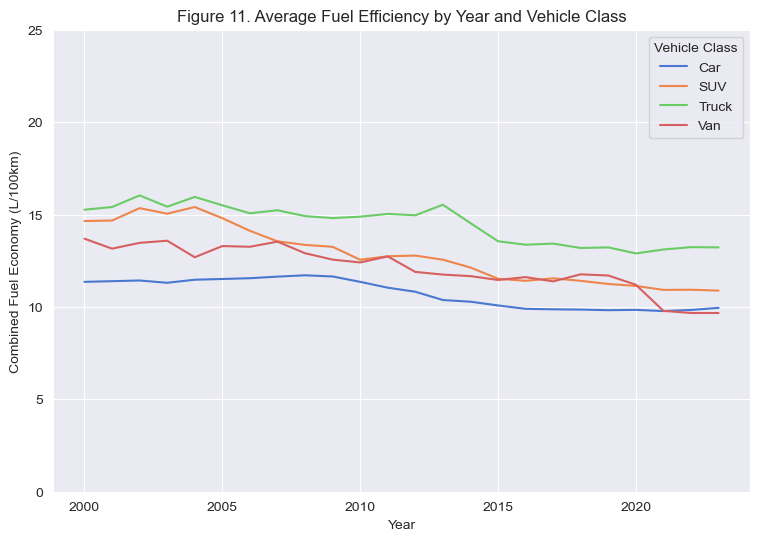

In [24]:
fuel_economy_by_year_and_vehicle_type = full_dataset.pivot_table(index="model_year", 
                                                                 columns="vehicle_class", 
                                                                 values="comb_lpkm", 
                                                                 aggfunc="mean")

ax = fuel_economy_by_year_and_vehicle_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Figure 11. Average Fuel Efficiency by Year and Vehicle Class")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Vehicle Class", loc='upper right')
plt.gcf().set_size_inches(9, 6)

In [25]:
original_average = fuel_economy_by_year_and_vehicle_type.T[2000]
new_average = fuel_economy_by_year_and_vehicle_type.T[2023]
percent_diff = abs(new_average - original_average)/original_average*100
percent_diff

vehicle_class
Car      12.389191
SUV      25.694914
Truck    13.357296
Van      29.362664
dtype: float64

From the figure above, it is observed that:
- All vehicle types have experienced an improvement in fuel efficiency from 2000 to 2023.

- Cars experienced the smallest improvement, at 12.4%. However, cars consistently had the best average fuel efficiency except for from 2021 to 2023.

- Trucks experienced a 13.4% improvement. They also had the worst average fuel efficiency across all the years examined.

- SUVs experienced a 25.7% improvement. They initially started with an average fuel efficiency close to trucks in 2000, but ended up with an average fuel efficiency closer to cars and vans in 2023.

- Vans experienced the largest improvement, at 29.4%. In 2021, they overtook cars as having the most efficient average fuel economy.

From these observations it can be concluded that if a consumer is in the market for a fuel-efficient vehicle, the impact of the model year on their decision differs depending on the type of vehicle they want. For instance, if they are interested in a fuel-efficient car or truck, the model year may not be as crucial as it would be if they were searching for a fuel-efficient SUV or van. In those cases, it would be advisable to consider newer vehicles if possible.

### 3.2.3 Interaction between Year and Fuel Type

For the average consumer, the primary fuel types to consider are premium or regular gasoline since diesel, ethanol, and natural gas vehicles are usually specialized. Some vehicle engines are manufactured to perform optimally when given higher octane fuel (premium gasoline), whereas for others regular gasoline is suffucicient. 

The figure below is used to compare the improvements in efficiency for each fuel type over time. 

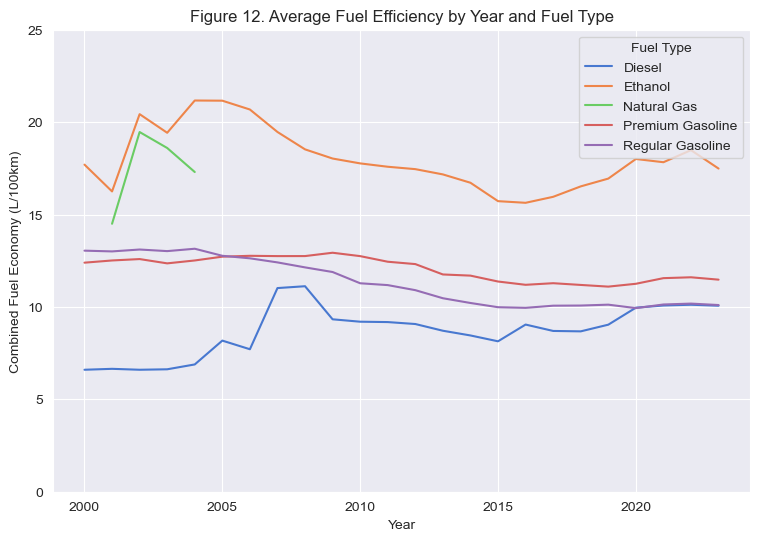

In [26]:
fuel_economy_by_year_and_fuel_type = full_dataset.pivot_table(index="model_year", 
                                                              columns="fuel_type", 
                                                              values="comb_lpkm", 
                                                              aggfunc="mean")
ax = fuel_economy_by_year_and_fuel_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Figure 12. Average Fuel Efficiency by Year and Fuel Type")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Fuel Type", loc='upper right')
plt.gcf().set_size_inches(9, 6)

Between regular and premium gasoline vehicles, regular gasoline vehicles have improved in efficiency the most since 2000. While premium gasoline vehicles started the century as the slightly more efficient fuel type, they by 2005 they were overtaken by regular gasoline vehicles. Regualar gasoline vehicles decreased their average combined fuel efficiency from around 13.0 L/100km in 2000 down to 10.1 L/100km in 2023, while premium gasoline vehicles only saw a decrease from 12.4 L/100km to 11.5 L/100km over that same time period. 

With regard to the other fuel types:
- Ethanol has the worst fuel economy out of all the fuel types. It also saw almost no improvement, starting at 17.7 L/100km in 2000 and ending at 17.5 L/100km in 2023.

- Natural gas was only used as a fuel source until 2004, and was similar in efficiency to ethanol. 

- Interestingly diesel is the only fuel source whose efficiency has worsened from 2000 to 2023, increasing from 6.6 L/100km to 10.0 L/100km. Despite this worsening in average fuel economy, it reamined the most efficient fuel source for the entire 2000 to 2023 period (although from 2020 onward it is practically tied with regular gasoline).

### 3.2.4 Interaction between Year and Transmission Type

Transmission type (beyond the distinction between manual and automatic), may be an overlooked factor when purchasing a vehicle. While it was observed in Figure 7 that continuously variable transmission vehicles tend to be more efficient overall, it begs the question how vehicle efficiency for each transmission type has changed over time. We explore these changes through a visualization and comparing the percent improvements. 

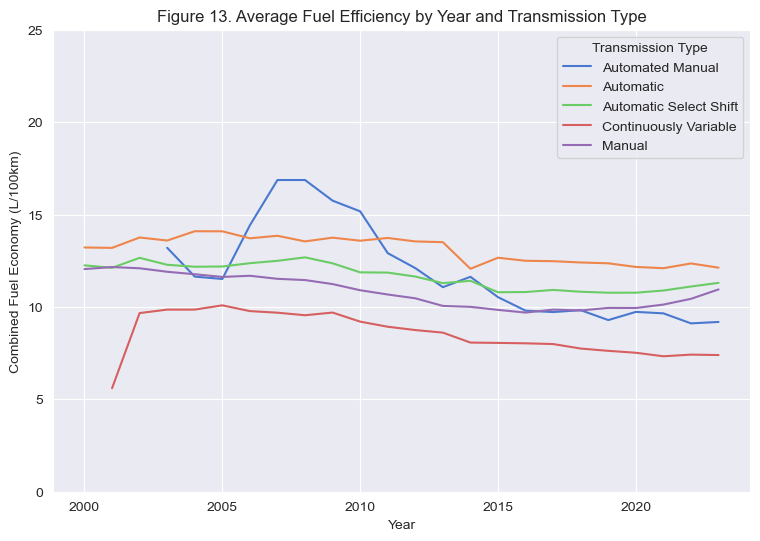

In [27]:
fuel_economy_by_year_and_transmission_type = full_dataset.pivot_table(index="model_year", 
                                                                      columns="transmission_type", 
                                                                      values="comb_lpkm", 
                                                                      aggfunc="mean")

ax = fuel_economy_by_year_and_transmission_type.plot.line()
ax.set_xlabel("Year")
ax.set_ylabel("Combined Fuel Economy (L/100km)")
ax.set_ylim(0, 25)
ax.set_title("Figure 13. Average Fuel Efficiency by Year and Transmission Type")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Transmission Type", loc='upper right')
plt.gcf().set_size_inches(9, 6)

In [28]:
original_average = fuel_economy_by_year_and_transmission_type.T[2003]
new_average = fuel_economy_by_year_and_transmission_type.T[2023]
percent_diff = abs(new_average - original_average)/original_average*100
percent_diff

transmission_type
Automated Manual          30.399449
Automatic                 10.798764
Automatic Select Shift     7.966974
Continuously Variable     24.951257
Manual                     8.025531
dtype: float64

For this comparison, 2003 was chosen as the baseline, since continuously variable transmissions (CVT) and automated manuals are a newer technology and were not prominent before then (hense the oddity in the CVT measurement from 2001 in the visualization above). 

Improvements in fuel efficiency by transmission type from 2002 to 2023, ranked from best to worst, are as follows:
- Automated Manual: 30.4%
- Continously Variable: 25.0%
- Automatic: 10.8%
- Manual: 8.0%
- Automatic Select Shift: 8.0%

Automatics have consistently been the least efficient for every year aside from 2006 to 2011 where automated manuals were worse. In contrast, CVT has consistently been the most efficient fuel type for every year since it's inception, and also boasts the second most improved fuel economy over the period from 2003 to 2023 (23.5%). It's clear then, that newer CVT vehicles are the optimal choice if available. For other transmission types, we see a much smaller improvement in average fuel economy over time. 

## 3.3 Most Efficient Vehicles and Makes

If a consumer is simply looking for the most efficient vehicle on the market, that can be easily determine as follows:

In [29]:
# finding the most efficient vehicle
min_ID = full_dataset["comb_lpkm"].idxmin()
most_efficient_comb_lpkm = full_dataset["comb_lpkm"][min_ID]
most_efficient_year = full_dataset["model_year"][min_ID]
most_efficient_make = full_dataset["make"][min_ID]
most_efficient_model = full_dataset["model"][min_ID]
print(f"The {most_efficient_make} {most_efficient_model} from {most_efficient_year} " + 
      f"was the most efficient vehicle at {most_efficient_comb_lpkm} L/100km")

# finding the least efficient vehicle
max_ID = full_dataset["comb_lpkm"].idxmax()
least_efficient_comb_lpkm = full_dataset["comb_lpkm"][max_ID]
least_efficient_year = full_dataset["model_year"][max_ID]
least_efficient_make = full_dataset["make"][max_ID]
least_efficient_model = full_dataset["model"][max_ID]
print(f"The {least_efficient_make} {least_efficient_model} from {least_efficient_year} " + 
      f"was the least efficient vehicle at {least_efficient_comb_lpkm} L/100km")

The Hyundai IONIQ Blue from 2022 was the most efficient vehicle at 4.0 L/100km
The Dodge RAM 1500 4X4 FFV from 2005 was the least efficient vehicle at 26.0 L/100km


It is noted that the 2022 Hyundai IONIQ Blue is the most efficient vehicle in our dataset, boasting a combined fuel economy of 4 L/100km. In contrast, the least efficient vehicle was the 2005 Dodge RAM 1500 4X4 FFV with a combined fuel economy of 26 L/100km. 

However price and functionality are also generally considerations when purchasing a vehicle. For example:
- Sometimes a consumer needs a van due a large family.

- Sometimes older vehicles are the only feasible option due to lower prices of used vehicles.

By separating each make by vehicle class and obtaining an average fuel economy for each year we can point consumers in the right direction based on their desired vehicle type and budget. 

In [30]:
# exploring which companies made the most efficient vehicles in each year, based on vehicle class
fuel_economy_by_year_make_and_vehicle_type = full_dataset.pivot_table(index=["model_year", "make"], 
                                                                      columns="vehicle_class", 
                                                                      values="comb_lpkm", 
                                                                      aggfunc="mean")

fuel_economy_by_year_make_and_vehicle_type.reset_index(["model_year"], inplace=True)
fuel_economy_by_year_make_and_vehicle_type

by_year = fuel_economy_by_year_make_and_vehicle_type.groupby("model_year")
by_year.idxmin()

vehicle_class,Car,SUV,Truck,Van
model_year,,,,
2000,Honda,Subaru,Nissan,Chevrolet
2001,Honda,Subaru,Toyota,Chevrolet
2002,Honda,Subaru,Mazda,Chevrolet
2003,Honda,Subaru,Toyota,Chevrolet
2004,Honda,Mazda,Mazda,Dodge
2005,Honda,Subaru,Mazda,Honda
2006,Honda,Subaru,Mazda,Honda
2007,Toyota,Subaru,Mazda,Toyota
2008,Toyota,Subaru,Mazda,Mazda


As can be seen in the table above, the most efficient make per year for each vehicle type changes year by year. In general:
- For cars, Honda appears to be a good choice for older vehicles, while Toyota is a good choice from 2007 to 2019.

- For SUVs, Subaru appears to be the most consisent manufacturer of efficient vehicles. Other manufacturers that are, on average, more efficient in certain years include Mazda, Hyundai, and Kia.

- For trucks and vans, various manufacturers were all the most efficient in different years, often for periods of several years in a row.

- For the newest cars, SUVs, and trucks (e.g., 2020 onwards), both Kia and Hyundai make very efficient vehicles.

## 4. Modelling and Predicting Fuel Efficiency

Predicting a vehicle's fuel economy could have wide ranging applications, such as whether a company should offer incentives on existing models because they will be less desireable in the future, or whether a consumer should purchase a vehicle this year versus waiting for next year's model. 

In Section 4.1, various models are fitted to the dataset (a linear regression model, a lasso model, a tree model, and a neural network) assuming no interactions between predictors. 

In Section 4.2, various models are fitted to the dataset (a linear regression model, a lasso model, a tree model, and a neural network) considering the interaction between each predictor and the model year.

In section 4.3 the best model is tested against new 2024 vehicles that have yet to be included in our data to assess the predictive power of the model.

### 4.1 Models With No Interactions

Prior to fitting any models, the data is split into training (75%) and testing (25%) sets. Categorical variables are defined where appropriate.

In [31]:
# create X and y training and testing datasets
y, X = patsy.dmatrices("comb_lpkm ~ model_year + C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears", full_dataset, return_type='matrix')
train = full_dataset.sample(frac = 0.75,random_state = 42) 
test = full_dataset.drop(train.index)
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

The first model fitted is a linear regresison model to predict combined fuel economy considering all parameters. For comparison with other models, the mean squared error is obtained on each of the training and testing data. 

In [32]:
# fit a linear regression model
fuel_efficiency_lr_model = linear_model.LinearRegression()
fuel_efficiency_lr_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lr_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lr_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.1562306525157753 and the MSE on the testing data is 1.146432967729984


Next a lasso model is fit, and mean squared error obtained on each of the training and testing data in order to see if there's any benefit to excluding some predictors. 

In [33]:
# fit a lasso regression model
fuel_efficiency_lasso_model = linear_model.Lasso()
fuel_efficiency_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 3.5598818771509877 and the MSE on the testing data is 3.5727824933361005


A comparison can then be performed of the different terms included in each model.

In [34]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
Intercept,0.000000,3.707734e-16
C(make)[T.Audi],-0.000000,8.779234e-01
C(make)[T.Bmw],-0.000000,3.937258e-01
C(make)[T.Buick],0.000000,4.292638e-01
C(make)[T.Cadillac],0.000000,8.221932e-01
C(make)[T.Chevrolet],0.000000,5.889257e-02
C(make)[T.Chrysler],-0.000000,4.483304e-01
C(make)[T.Dodge],0.000000,5.083677e-01
C(make)[T.Ford],0.000000,6.066483e-01
C(make)[T.Gmc],0.000000,2.456136e-01


A higher MSE for both the training and testing data is obtained the lasso model (training MSE = 3.56, testing MSE = 3.57), suggesting that the original linear regression model (training MSE = 1.16, testing MSE = 1.15) is a more effective predictor. 

It is noted that in the lasso model, the three most influental predictors are cylinders, engine size, and model year. However, perhaps a better lasso model can be obtained by performing 5-fold cross-validation to optimize alpha. 

Text(-0.8334944602183618, 8.731803803987514, '5 fold cross-validation')

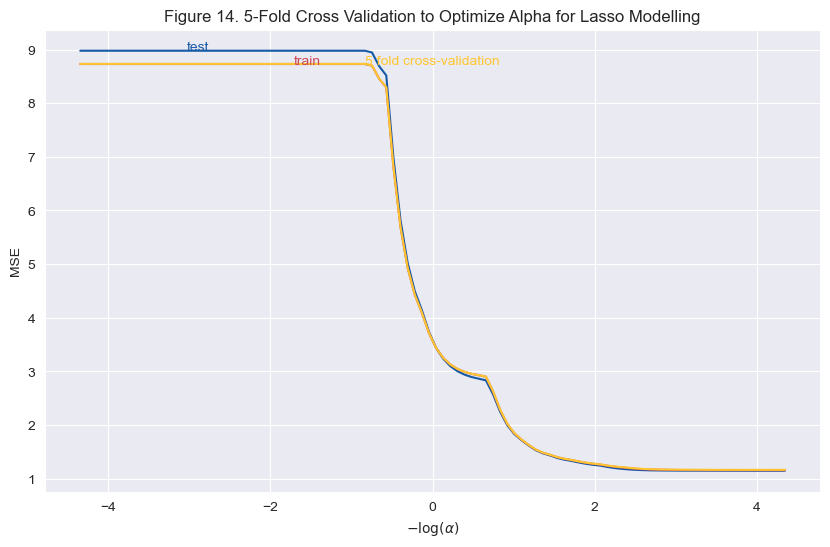

In [35]:
# number of cross-validation folds
k = 5

# create a function for calculating mses
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

# create the alphas and mse values for different alphas
alphas = np.exp(np.linspace(10, -10, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  X_train, y_train, cv=k, scoring='neg_mean_squared_error'))
          for alpha in alphas]

# create the plot
colors = ['#165aa7', '#cb495c', '#fec630']
fig, ax = plt.subplots(figsize=(10,6))
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.set_title("Figure 14. 5-Fold Cross Validation to Optimize Alpha for Lasso Modelling")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])
ax.annotate(f"{k} fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])

In [36]:
#retrieve optimal alpha
lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train.flatten())
neg_log_alpha = -np.log10(lasso.alpha_)
optimal_alpha = 10**(-1 * neg_log_alpha)
print(f"The optimal alpha is {optimal_alpha}")

The optimal alpha is 0.005686607057392215


Performing the 5-fold cross validation, the optimal alpha value is 0.0057. The lasso model can be updated to utilize this alpha value.

In [37]:
# fit an updated lasso regression model with an alpha to optimize MSE
fuel_efficiency_lasso_model = linear_model.Lasso(alpha=optimal_alpha)
fuel_efficiency_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.2207164816616252 and the MSE on the testing data is 1.1958587046781672


In [38]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
Intercept,0.000000,3.707734e-16
C(make)[T.Audi],0.301645,8.779234e-01
C(make)[T.Bmw],-0.000000,3.937258e-01
C(make)[T.Buick],0.000000,4.292638e-01
C(make)[T.Cadillac],0.137412,8.221932e-01
C(make)[T.Chevrolet],-0.268473,5.889257e-02
C(make)[T.Chrysler],0.000000,4.483304e-01
C(make)[T.Dodge],0.014153,5.083677e-01
C(make)[T.Ford],0.189748,6.066483e-01
C(make)[T.Gmc],-0.029793,2.456136e-01


In this optimized lasso model, the inclusion of more predictors has reduced the MSE considerably (training MSE = 1.22, testing MSE = 1.20)compared to the old lasso model (training MSE = 3.56, testing MSE = 3.57). However, it is still higher than the MSE of the original linear regression model (training MSE = 1.16, testing MSE = 1.15).

A regression tree can be modelling to assess if it is able to improve the MSE of the testing data. Various depths of the tree are tested in order to optimize the MSE on the testing set.

In [39]:
# fitting a regression tree
depths = [5, 10, 15, 20, 25, 30]
for depth in depths:
    fuel_efficiency_fitted_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=123).fit(X_train,y_train)
    mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_fitted_tree.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_fitted_tree.predict(X_test))
    print(f"With depth {depth}, the MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

With depth 5, the MSE on the training data is: 1.582550239614631 and the MSE on the testing data is 1.6859932362832024
With depth 10, the MSE on the training data is: 0.6429651732258016 and the MSE on the testing data is 0.7796143581367635
With depth 15, the MSE on the training data is: 0.28206535891976536 and the MSE on the testing data is 0.5414509686523233
With depth 20, the MSE on the training data is: 0.19843555360148868 and the MSE on the testing data is 0.5291956921451613
With depth 25, the MSE on the training data is: 0.18122228534018578 and the MSE on the testing data is 0.5325569144647978
With depth 30, the MSE on the training data is: 0.1785449419803935 and the MSE on the testing data is 0.5370911686596977


For the regression tree, the optimal depth is 20 where the testing MSE of 0.529 is an improvement over any of the previous models. The model might be overfitting however, as the training MSE is lower at 0.20.

Finally, a neural network is considered. Data is scaled, and various combinations of hidden layers are tested in order to optimize the MSE on the testing set.

In [40]:
# fitting a neural network

hidden_layers = [(10,10), (50, 50), (100, 100), (200, 200), (10, 10, 10), (100, 100, 100)]
for hidden_layer in hidden_layers:

    fuel_efficiency_nn_scaled_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        neural_network.MLPRegressor(hidden_layer, max_iter=500, random_state=123)
    )
 
    fuel_efficiency_nn_scaled_model.fit(X_train, y_train.flatten())
    mse_nn_train = metrics.mean_squared_error(y_train, fuel_efficiency_nn_scaled_model.predict(X_train))
    mse_nn_test = metrics.mean_squared_error(y_test, fuel_efficiency_nn_scaled_model.predict(X_test))
    print(f"With a hidden layer of {hidden_layer} the MSE on the training data is: {mse_nn_train} and the MSE on the testing data is {mse_nn_test}")

With a hidden layer of (10, 10) the MSE on the training data is: 0.7273946925079895 and the MSE on the testing data is 0.7960818314346311
With a hidden layer of (50, 50) the MSE on the training data is: 0.4174689431653696 and the MSE on the testing data is 0.5176084306514511
With a hidden layer of (100, 100) the MSE on the training data is: 0.34313776085309255 and the MSE on the testing data is 0.444381663258462
With a hidden layer of (200, 200) the MSE on the training data is: 0.4257459699173968 and the MSE on the testing data is 0.5195028259160941
With a hidden layer of (10, 10, 10) the MSE on the training data is: 0.7315525730387489 and the MSE on the testing data is 0.7988001809338519
With a hidden layer of (100, 100, 100) the MSE on the training data is: 0.38141913038113257 and the MSE on the testing data is 0.479076605395392


The neural network with a hidden layer of (100, 100) boasts the lowest testing MSE at 0.444 (and a training MSE of 0.343, so the model is not dramatically overfitting). This model is yet another improvement over any of the previous models.

In [41]:
# defining the best model with no interaction
fuel_efficiency_best_nn_scaled_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        neural_network.MLPRegressor((100,100), max_iter=500, random_state=123)
    )
 
fuel_efficiency_best_nn_scaled_model.fit(X_train, y_train.flatten())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500,
                              random_state=123))])

### 4.2 Models With Interactions With Year

As observed in Section 3.2, several predictors appeared to have a relationship with year.

Accordingly, the model fitting process from Section 4.1 will be repeated, but this time accounting for the possible interaction between the model year and each of our predictors.

Prior to fitting any models, the data is split into training (75%) and testing (25%) sets. Categorical variables are defined where appropriate, and the interaction with model year is accounted for.

In [42]:
# create X and y training and testing datasets
y, X = patsy.dmatrices("comb_lpkm ~ model_year*(C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears)", full_dataset, return_type='matrix')
train = full_dataset.sample(frac = 0.75,random_state = 42) 
test = full_dataset.drop(train.index)
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

The first model fitted is a linear regresison model to predict combined fuel economy considering all parameters with interactions with model year.

In [43]:
# fit a linear regression model
fuel_efficiency_interaction_lr_model = linear_model.LinearRegression()
fuel_efficiency_interaction_lr_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_lr_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_lr_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.027509786300692 and the MSE on the testing data is 1.0295739527736776


Next a lasso model is fit, and mean squared error obtained on each of the training and testing data in order to see if there's any benefit to excluding some predictors.

In [44]:
# fit a lasso regression model
fuel_efficiency_interaction_lasso_model = linear_model.Lasso()
fuel_efficiency_interaction_lasso_model.fit(X_train, y_train)

mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_lasso_model.predict(X_train))
mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_lasso_model.predict(X_test))

print(f"The MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

The MSE on the training data is: 1.2159766801095757 and the MSE on the testing data is 1.2239638351431612


A comparison can then be performed of the different terms included in each model.

In [45]:
param_names = X.design_info.column_names
lasso_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_interaction_lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(param_names, fuel_efficiency_interaction_lr_model.coef_[0])))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
Intercept,0.000000,-3.156170e-09
C(make)[T.Audi],0.000000,2.837126e+01
C(make)[T.Bmw],0.000000,-4.924007e+01
C(make)[T.Buick],0.000000,-2.075368e+02
C(make)[T.Cadillac],0.000000,-9.892516e+01
C(make)[T.Chevrolet],-0.000000,-1.643213e+02
C(make)[T.Chrysler],0.000000,-6.304511e+01
C(make)[T.Dodge],0.000000,-4.814839e+01
C(make)[T.Ford],0.000000,-2.046712e+02
C(make)[T.Gmc],-0.000000,-1.144062e+02


Despite not specifying an optimal alpha value, the lasso model is much less discriminate this time. Various parameters are included, although with a preference towards parameters that have the interaction with year. Despite this, the lasso model still has a higher MSE for both the training and testing data (training MSE = 1.22, testing MSE = 1.22) compared to the linear regression model (training MSE = 1.03, testing MSE = 1.03).

As in the previous section, a regression tree will be fitted to the data.

In [46]:
# fitting a regression tree
depths = [5, 10, 15, 20, 25, 30]
for depth in depths:
    fuel_efficiency_fitted_tree = tree.DecisionTreeRegressor(max_depth=depth, random_state=123).fit(X_train,y_train)
    mse_train = metrics.mean_squared_error(y_train, fuel_efficiency_fitted_tree.predict(X_train))
    mse_test = metrics.mean_squared_error(y_test, fuel_efficiency_fitted_tree.predict(X_test))
    print(f"With depth {depth}, the MSE on the training data is: {mse_train} and the MSE on the testing data is {mse_test}")

With depth 5, the MSE on the training data is: 1.5801037971574687 and the MSE on the testing data is 1.6790342302529808
With depth 10, the MSE on the training data is: 0.6272940884923738 and the MSE on the testing data is 0.7941216006781947
With depth 15, the MSE on the training data is: 0.2806889035755023 and the MSE on the testing data is 0.5603232564199807
With depth 20, the MSE on the training data is: 0.20710464001966303 and the MSE on the testing data is 0.5637054059361509
With depth 25, the MSE on the training data is: 0.18755786963641724 and the MSE on the testing data is 0.5617101774094356
With depth 30, the MSE on the training data is: 0.1807443961126348 and the MSE on the testing data is 0.5666674417499687


For the regression tree, the optimal depth is 15 where the testing MSE of 0.560 is an improvement over any of the previous models. The model might be overfitting however, as the training MSE is lower at 0.28.

Interestingly, despite this model including interaction with year, the corresponding regression tree model from Section 4.1 wihtout the interaction has a slighly lower testing MSE of 0.529.

Finally, a neural network is considered. Data is scaled, and various combinations of hidden layers are tested in order to optimize the MSE on the testing set.

In [47]:
# fitting a neural network
hidden_layers = [(10,10), (50, 50), (100, 100), (200, 200), (10, 10, 10), (100, 100, 100)]
for hidden_layer in hidden_layers:

    fuel_efficiency_interaction_nn_scaled_model = pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        neural_network.MLPRegressor(hidden_layer, max_iter=500, random_state=123)
    )
 
    fuel_efficiency_interaction_nn_scaled_model.fit(X_train, y_train.flatten())
    mse_nn_train = metrics.mean_squared_error(y_train, fuel_efficiency_interaction_nn_scaled_model.predict(X_train))
    mse_nn_test = metrics.mean_squared_error(y_test, fuel_efficiency_interaction_nn_scaled_model.predict(X_test))
    print(f"With a hidden layer of {hidden_layer} the MSE on the training data is: {mse_nn_train} and the MSE on the testing data is {mse_nn_test}")

With a hidden layer of (10, 10) the MSE on the training data is: 0.7256596651876062 and the MSE on the testing data is 0.8052945443028502
With a hidden layer of (50, 50) the MSE on the training data is: 0.4580857508664807 and the MSE on the testing data is 0.5612161506059379
With a hidden layer of (100, 100) the MSE on the training data is: 0.4098404533394098 and the MSE on the testing data is 0.5040240835919705
With a hidden layer of (200, 200) the MSE on the training data is: 0.7119101973191847 and the MSE on the testing data is 0.7978146852526011
With a hidden layer of (10, 10, 10) the MSE on the training data is: 0.7457432229440741 and the MSE on the testing data is 0.8072546711162485
With a hidden layer of (100, 100, 100) the MSE on the training data is: 0.4020961262616707 and the MSE on the testing data is 0.49711154285540715


As with the non-interactive predictors, the neural network for the ineractions with year yields the lowest MSE at 0.504. 

The neural network with a hidden layer of (100, 100) boasts the lowest testing MSE at 0.504 (and a training MSE of 0.410, so the model is not dramatically overfitting). This model is yet another improvement over any of the previous models with interaction terms.

However, the corresponding neural network from Section 4.1 with no interaction terms had a lower testing MSE at 0.444. As such, the neural network with interactions with year will not be utilized to predict future fuel efficiency. Instead the neural network without interactions will be used.

### 4.3 Predicting Fuel Efficiency of 2024 Vehicles

This project will use the best model fitted to the dataset (i.e., the neural network with no interactions with year) to attempt to predict the fuel efficiency of future vehicles. Specifically, the model was trained on vehicle data from 2000 to 2023, and it will be utilized to predict the fuel efficiency of several announced 2024 vehicles.

Several vehicles announced to be released in 2024 include:
- 2024 Ford F-150 (a truck) with a 3.5L V6 gasoline engine and 10 speed automatic transmission, that gets an estimated 11.7 L/100km

- 2024 Honda Civic (a car) with a 2.0L 4-Cylinder gasoline engine and continuously variable transmission, that gets an estimated 6.5 L/100km

- 2024 Mazda CX-90 (a SUV) with a 3.3L V6 premium gasoline engine and 8 speed automatic transmission, that gets an estimated 9.4 L/100km

- 2024 Kia Carnival (a van) with a 3.5L V6 gasoline engine and 8 speed automatic transmission, that gets an estimated 10.7 L/100km

- 2024 Chevrolet Trax (a SUV) with a 1.2L 3-Cylinder gasoline engine and a 6 speed automatic transmission, that gets an estimated 7.8 L/100 km

- 2024 Hyundai Elantra (a car) with a 2.0L 4-Cylinder gasoline engine and continuously variable transmission, that gets an estimated 6.2 L/100km

- 2024 Chevrolet Silverado 1500 (a truck) with a 3.0L 6-Cylinder diesel engine and a 10 speed automatic transmission, that gets an estimated 9.0 L/100km

Note that most 2024 models aren't officially published on manufacturer's websites, so this data was obtained from the following sources:
- https://www.edmunds.com/ford/f-150/2024/#:~:text=EPA%2Destimated%20fuel%20economy%20is,V8%2Dequipped%20Silverado%20or%20Ram
- https://www.caranddriver.com/honda/civic
- https://www.caranddriver.com/news/a42789780/2024-mazda-cx-90-power-mpg-specs/
- https://driving.ca/kia/carnival/
- https://www.caranddriver.com/chevrolet/trax
- https://www.caranddriver.com/hyundai/elantra
- https://www.motortrend.com/cars/chevrolet/silverado-1500/2024/

Based on the gathered data, a new dataset is created with the relevant information for the selected 2024 vehicles. It is then concatenated to the existing dataset.

In [48]:
# creating the dataset
data = {"model_year": [2024, 2024, 2024, 2024, 2024, 2024, 2024],
                 "make": ["Ford", "Honda", "Mazda", "Kia", "Chevrolet", "Hyundai", "Chevrolet"],
                 "model": ["F-150", "Civic", "CX-90", "Carnival", "Trax", "Elantra", "Silverado 1500"],
                 "vehicle_class": ["Truck", "Car", "SUV", "Van", "SUV", "Car", "Truck"],
                 "fuel_type": ["Regular Gasoline", "Regular Gasoline", "Premium Gasoline", "Regular Gasoline", 
                               "Regular Gasoline", "Regular Gasoline", "Diesel"],
                 "engine_size_L": [3.5, 2, 3.3, 3.5, 1.2, 2.0, 3.0],
                 "cylinders": [6.0, 4.0, 6.0, 6.0, 3.0, 4.0, 6.0],
                 "transmission_type": ["Automatic", "Continuously Variable", "Automatic", "Automatic", 
                                       "Automatic", "Continuously Variable", "Automatic"],
                 "transmission_gears": [10, 1, 8, 8, 6, 1, 10],
                 "comb_lpkm": [11.7, 6.5, 9.4, 10.7, 7.8, 6.2, 9.0]}

vehicles_to_predict = pd.DataFrame(data)
full_dataset_with_predictions = pd.concat([full_dataset, vehicles_to_predict])
full_dataset_with_predictions.reset_index(drop=True,inplace=True)
full_dataset_with_predictions.loc[full_dataset_with_predictions.index[-7]:full_dataset_with_predictions.index[-1],:]

,model_year,make,model,vehicle_class,fuel_type,engine_size_L,cylinders,transmission_type,transmission_gears,comb_lpkm
18938,2024,Ford,F-150,Truck,Regular Gasoline,3.5,6.0,Automatic,10,11.7
18939,2024,Honda,Civic,Car,Regular Gasoline,2.0,4.0,Continuously Variable,1,6.5
18940,2024,Mazda,CX-90,SUV,Premium Gasoline,3.3,6.0,Automatic,8,9.4
18941,2024,Kia,Carnival,Van,Regular Gasoline,3.5,6.0,Automatic,8,10.7
18942,2024,Chevrolet,Trax,SUV,Regular Gasoline,1.2,3.0,Automatic,6,7.8
18943,2024,Hyundai,Elantra,Car,Regular Gasoline,2.0,4.0,Continuously Variable,1,6.2
18944,2024,Chevrolet,Silverado 1500,Truck,Diesel,3.0,6.0,Automatic,10,9.0


As mentioned in Section 4.1 and 4.2, the neural network (with hidden layers of (100, 100)) with no interaction with year yielded the lowest MSE on the testing data. Accordingly, this model is used to predict the efficiency of the 2024 vehicles. The code below performs this prediction, and displays a table showing the predicted efficiency, actual efficiency, and percent difference for each of the 2024 vehicles.

In [49]:
# using the best neural network model with no interaction
y, X = patsy.dmatrices("comb_lpkm ~ model_year + C(make) + C(vehicle_class) + " +
                       "C(fuel_type) + engine_size_L + cylinders + C(transmission_type) + " +
                        "transmission_gears", full_dataset_with_predictions, return_type='matrix')
test_vehicles = X[-7:,:]
predicted_efficiency = fuel_efficiency_best_nn_scaled_model.predict(test_vehicles)
predicted_efficiency = predicted_efficiency.flatten()
actual_efficiency = y[-7:]
actual_efficiency = actual_efficiency.flatten()
percent_error = abs(predicted_efficiency-actual_efficiency)/actual_efficiency*100
vehicle_names = ("2024 Ford F150", "2024 Honda Civic", "2024 Mazda CX-90", "2024 Kia Carnival", 
                 "2024 Chevrolet Trax", "2024 Hyundai Elantra", "2024 Chevrolet Silverado 1500")
predicted = pd.Series(dict(zip(vehicle_names, predicted_efficiency)))
actual = pd.Series(dict(zip(vehicle_names, actual_efficiency)))
difference = pd.Series(dict(zip(vehicle_names, percent_error)))
result = pd.DataFrame(dict(predicted_efficiency=predicted, actual_efficiency=actual, percent_difference=difference))
result

,predicted_efficiency,actual_efficiency,percent_difference
2024 Ford F150,11.596046,11.7,0.888496
2024 Honda Civic,7.028889,6.5,8.136759
2024 Mazda CX-90,11.074998,9.4,17.819131
2024 Kia Carnival,11.634208,10.7,8.730918
2024 Chevrolet Trax,7.644308,7.8,1.996049
2024 Hyundai Elantra,6.613821,6.2,6.674524
2024 Chevrolet Silverado 1500,9.778465,9.0,8.649611


Overall the model predicts the fuel economy of these unreleased vehicles within 10% of the actual value in 6 out of 7 cases. However, overpredicts the 2024 Mazda CX-90 by almost 18%. 

The model may have a bias towards overpredicting fuel economy of future models, as the predicted efficiency was above the actual efficiency is 6 of the 7 cases, although the sample size is too small to draw meaningful conclusions. 

# 5. R&D Spending

While the model above does a great job at predicting vehicle efficiency, it also requires a great deal of information about the vehicle itself in order to make that prediction. It may, however, be useful to be able to predict the efficiency of vehicles based on historical data alone. 

One potential solution involves leveraging a company's research and development expenses to predict future fuel efficiency. Since efficiency improvements require significant investment in R&D, it follows that incorporating data on previous efficiency levels and R&D expenses could predict future efficiency levels. If past year's R&D expenses are a good predictor of future efficiency, the company's forcasted spending alongside present day efficiency could be used to predict the improvements in efficiency of next year's model. That way, consumers can determine the efficiency increase they can expect by waiting a year to purchase next year's model without knowing anything specific about the model (e.g., engine size, transmission type, etc.).

The first step is to obtain R&D expense data from annual financial reports. To do so, the tabula library can be used to parse tables from the PDF files, then locate and extract the R&D expenses. 

Toyota was selected since they are a prominent manufacturer across all vehicle classes, providing a versatile source of data throughout this analysis.

In [50]:
def retrieve_toyota_rnd_exp(url):
    """
    Parse the RnD Expense for each year from the given url (pdf file of Toyota FY financial results)
    Returns a dict with years and RnD expense (billions of yen).
    
    The parser was designed to handle variations in structure and language that exist among the different 
    formats of the PDF files.
    """
    
    rnd_regex = re.compile(r"(?:R&D|Research & Development)", flags=re.IGNORECASE)

    # extract all tables from the pdf
    all_dfs = tabula.read_pdf(url, pages='all', multiple_tables=True)
    
    def locate_rnd_table(all_dfs):
        """Locate the DataFrame containing the R&D expense data from the list of parsed dfs"""
        for df in all_dfs:
            string_cols = df.select_dtypes(include=['object']).columns
            if df[string_cols].apply(lambda col: col.str.contains(rnd_regex, na=False)).any().any():
                RnD_df = df
                RnD_df.reset_index(drop=True, inplace=True)
                break
        RnD_df = RnD_df.set_index(RnD_df.columns[0])
        return RnD_df
    
    RnD_df = locate_rnd_table(all_dfs)
    
    def locate_annual_rnd_columns(RnD_df):
        """Locate the columns containing the R&D expense data from the given DataFrame"""
        # remove forecast/prospects column
        RnD_df = RnD_df.drop(columns=[col for col in RnD_df.columns if 'Forecast' in col or 'Prospects' in col])
        RnD_df = RnD_df.drop(columns=[col for col in RnD_df.columns if 
                                      RnD_df.applymap(lambda x: 'Forecast' in str(x) or 
                                                      'Prospects' in str(x))[col].any()])

        # since the df has unlabeled quarterly and annual data, by assumption - keeping only the two columns 
        #   with the largest R&D expense values will give us the annual columns
        rnd_row = RnD_df.loc[RnD_df.index.str.contains(rnd_regex, na=False)].dropna(axis=1)
        has_spaces = rnd_row.applymap(lambda x: ' ' in str(x))
        drop_cols = has_spaces.any(axis=0)
        rnd_row = rnd_row.loc[:, ~drop_cols]
        rnd_row = rnd_row.replace('[^0-9\.]+', '', regex=True).astype(float)
        largest_val_cols = rnd_row.apply(lambda row: row.nlargest(2).index.tolist(), axis=1)
        selected_cols = [col for col in RnD_df.columns if col in largest_val_cols[0]]
        filtered_RnD_df = RnD_df.loc[:, selected_cols]
        
        return filtered_RnD_df

    filtered_RnD_df = locate_annual_rnd_columns(RnD_df)
    
    def find_rnd_years(filtered_RnD_df, url):
        """Get the years corresponding to the R&D data from the url, then set them as the column names in the df"""
        year2 = int(re.findall(r'20\d{2}', url)[0])
        year1 = year2-1
        filtered_RnD_df.columns = [year1, year2]

        return filtered_RnD_df

    find_rnd_years(filtered_RnD_df, url)

    def create_dict(filtered_RnD_df):
        """Create a dict with the years as keys, and corresponding R&D expense as values"""
        toyota_rnd_expenses = filtered_RnD_df.loc[filtered_RnD_df.index.str.contains(rnd_regex).fillna(False)]
        toyota_rnd_dict = toyota_rnd_expenses.iloc[0].to_dict()
        for key, value in toyota_rnd_dict.items():
            toyota_rnd_dict[key] = float(value.replace(",",""))
        
        return toyota_rnd_dict
    
    toyota_rnd_dict = create_dict(filtered_RnD_df)
    
    return toyota_rnd_dict

In [51]:
toyota_rnd_21_22 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2022_4q_summary_en.pdf")
toyota_rnd_19_20 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/2020_4q_summary_en.pdf")
toyota_rnd_17_18 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2018_summary.pdf")
toyota_rnd_15_16 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2016_consolidated.pdf")
toyota_rnd_13_14 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2014_consolidated.pdf")
toyota_rnd_11_12 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_9_2012_consolidated.pdf")
toyota_rnd_09_10 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2010_consolidated.pdf")
toyota_rnd_07_08 = retrieve_toyota_rnd_exp("https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_8_2008_consolidated.pdf")
toyota_rnd_05_06 = retrieve_toyota_rnd_exp('https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_10_2006_consolidated.pdf')
toyota_rnd_03_04 = retrieve_toyota_rnd_exp('https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_11_2004_consolidated.pdf')
toyota_rnd_01_02 = retrieve_toyota_rnd_exp('https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_13_2002_Highlights_Consolidated.pdf')
toyota_rnd_00_01 = retrieve_toyota_rnd_exp('https://global.toyota/pages/global_toyota/ir/financial-results/archives/en/May_16_2001_Highlights_Unconsolidated.pdf')

JavaNotFoundError: `java` command is not found from this Python process.Please ensure Java is installed and PATH is set for `java`

In [ ]:
rnd_dicts = [toyota_rnd_00_01, toyota_rnd_01_02, toyota_rnd_03_04, toyota_rnd_05_06, toyota_rnd_07_08,
            toyota_rnd_09_10, toyota_rnd_11_12, toyota_rnd_13_14, toyota_rnd_15_16, toyota_rnd_17_18,
            toyota_rnd_19_20, toyota_rnd_21_22]
toyota_rnd = {}
for dict in rnd_dicts:
    toyota_rnd.update(dict)
print(toyota_rnd)

{2000: 402.8, 2001: 479.9, 2002: 592.5, 2003: 668.4, 2004: 682.2, 2005: 755.1, 2006: 812.6, 2007: 890.7, 2008: 958.8, 2009: 904.0, 2010: 725.3, 2011: 730.3, 2012: 779.8, 2013: 807.4, 2014: 910.5, 2015: 1004.5, 2016: 1055.6, 2017: 1037.5, 2018: 1064.2, 2019: 1048.8, 2020: 1110.3, 2021: 1090.4, 2022: 1124.2}


Since we want to use the previous year's R&D expense data to predict the subsequent year's efficiency, we'll need to shift the R&D expense data to align the columns. 

In [ ]:
aligned_toyota_rnd = {key+1: value for key, value in toyota_rnd.items()}
print(aligned_toyota_rnd)

{2001: 402.8, 2002: 479.9, 2003: 592.5, 2004: 668.4, 2005: 682.2, 2006: 755.1, 2007: 812.6, 2008: 890.7, 2009: 958.8, 2010: 904.0, 2011: 725.3, 2012: 730.3, 2013: 779.8, 2014: 807.4, 2015: 910.5, 2016: 1004.5, 2017: 1055.6, 2018: 1037.5, 2019: 1064.2, 2020: 1048.8, 2021: 1110.3, 2022: 1090.4, 2023: 1124.2}


Next we'll examine the relationship between the vehicle information and rnd expense data. The goal is to use the previous years vehicle information and Toyota's R&D expense to try and predict the current year's combined fuel economy. 

We start by adding the parsed R&D expense data to the vehicle information, and visualize the data. We'll separate the vehicles by vehicle class, since oftentimes consumers will enter the market with the need for a specific vehicle class (ie. a construction worker might need a truck for their job, or a family with children may need an SUV...), and use the average fuel economy of each year for each class to build our model. 

In [ ]:
toyota_dataset = full_dataset[full_dataset['make'] == 'Toyota'][['model_year', 'vehicle_class', 'comb_lpkm']].sort_values('model_year')
toyota_dataset['rnd_expense'] = toyota_dataset['model_year'].map(aligned_toyota_rnd)
toyota_dataset

,model_year,vehicle_class,comb_lpkm,rnd_expense
16370,2000,Truck,15.8,NaN
16354,2000,SUV,11.2,NaN
16355,2000,SUV,10.2,NaN
16356,2000,SUV,10.1,NaN
16357,2000,SUV,10.9,NaN
...,...,...,...,...
626,2023,SUV,6.7,1124.2
625,2023,SUV,6.7,1124.2
624,2023,SUV,9.9,1124.2
633,2023,SUV,11.7,1124.2


In [ ]:
averaged_toyota_dataset = toyota_dataset.groupby(['model_year', 'vehicle_class']).mean().reset_index()

fig = px.scatter_3d(averaged_toyota_dataset, 
                    x='model_year', 
                    y='rnd_expense', 
                    z='comb_lpkm',
                    color='vehicle_class')
fig.update_layout(title='Figure 15. The Relationship of R&D Expense Over Time on Average Toyota Fuel Economy',
                  scene={'xaxis_title':'Model Year',
                         'yaxis_title':'R&D Expense (billions of yen)',
                         'zaxis_title':'Combined Fuel Economy'},
                  legend_title='Vehicle Class',
                  width=1000, height=800)
fig.show()

One thing that immediately sticks out from the plot is the precipitous drop in fuel economy of Toyota vans in 2021. In 2021, Toyota vans switched to continuously variable transmission, which led to a significant increase in efficiency. We will continue the analysis using the whole range of van data (as using only the two years since the switch in transmission type is likely to be inaccurate) with the note that this regression is likely to overpredict fuel economy for upcoming models of vans. 

Now that we have a plot, we can create a regression plane for each vehicle class, and add it to the visualization.

First we'll want to check if the inclusion of R&D expense information is helping the model. We do so by comparing the MSE both with and without the R&D expense data included. 

In [ ]:
toyota_cars = toyota_dataset[toyota_dataset['vehicle_class'] == 'Car'].copy()
toyota_SUVs = toyota_dataset[toyota_dataset['vehicle_class'] == 'SUV'].copy()
toyota_trucks = toyota_dataset[toyota_dataset['vehicle_class'] == 'Truck'].copy()
toyota_vans = toyota_dataset[toyota_dataset['vehicle_class'] == 'Van'].copy()

toyota_subsets = [toyota_cars, toyota_SUVs, toyota_trucks, toyota_vans]

In [ ]:
regression_dict = {}

for subset in toyota_subsets:
    make = subset['vehicle_class'].iloc[0]
    length = len(subset)
    subset.dropna(inplace=True)
    X_year_alone = subset[['model_year']].copy()
    y = subset['comb_lpkm']
    lr_model_year_alone = linear_model.LinearRegression()
    lr_model_year_alone.fit(X_year_alone, y)

    mse_year_alone = metrics.mean_squared_error(y, lr_model_year_alone.predict(X_year_alone))
    
    print(f"Model for {make} with year alone: mse = {mse_year_alone}")
    
    lr_model_with_rnd = linear_model.LinearRegression()
    X_with_rnd = subset[['model_year', 'rnd_expense']].copy()
    lr_model_with_rnd.fit(X_with_rnd, y)
    
    beta_0 = lr_model_with_rnd.intercept_
    beta_1 = lr_model_with_rnd.coef_[0]
    beta_2 = lr_model_with_rnd.coef_[1]
    
    mse_with_rnd = metrics.mean_squared_error(y, lr_model_with_rnd.predict(X_with_rnd))
    
    print(f"Model for {make} with R&D expense: mse = {mse_with_rnd}")

Model for Car with year alone: mse = 2.5964739135895107
Model for Car with R&D expense: mse = 2.5940816695477054
Model for SUV with year alone: mse = 5.718884995756828
Model for SUV with R&D expense: mse = 5.696772116895332
Model for Truck with year alone: mse = 3.001175116284103
Model for Truck with R&D expense: mse = 2.9982356709670746
Model for Van with year alone: mse = 1.9204152946337993
Model for Van with R&D expense: mse = 1.878675296437409


Unsurprisingly, for all vehicle classes the MSE is slightly lower for the regression including the R&D expense data. As such, going forward we will include the R&D expense data in our model. 

In [ ]:
regression_dict = {}

for subset in toyota_subsets:
    make = subset['vehicle_class'].iloc[0]
    length = len(subset)
    subset.dropna(inplace=True)
    lr_model_with_rnd = linear_model.LinearRegression()
    X_with_rnd = subset[['model_year', 'rnd_expense']].copy()
    y = subset['comb_lpkm']

    lr_model_with_rnd.fit(X_with_rnd, y)
    
    beta_0 = lr_model_with_rnd.intercept_
    beta_1 = lr_model_with_rnd.coef_[0]
    beta_2 = lr_model_with_rnd.coef_[1]
    
    regression_dict.update({subset['vehicle_class'].iloc[0]:{'beta_0':beta_0,
                      'beta_1':beta_1,
                      'beta_2':beta_2}})
        
    print(f"Model for {make}: \n Combined Fuel Economy = {beta_0} + {beta_1} * Model Year + {beta_2}" + 
          f" * R&D Expense")

Model for Car: 
 Combined Fuel Economy = 278.3918252318487 + -0.1345823385332473 * Model Year + 0.0006109750081191417 * R&D Expense
Model for SUV: 
 Combined Fuel Economy = 538.0924233556232 + -0.2624679108795513 * Model Year + 0.0017471730154143582 * R&D Expense
Model for Truck: 
 Combined Fuel Economy = 181.63320196306415 + -0.0838296093302065 * Model Year + 0.0006040939383946449 * R&D Expense
Model for Van: 
 Combined Fuel Economy = 588.9863851161136 + -0.2882011756304393 * Model Year + 0.002609210567852032 * R&D Expense


We can use the best fit equations to plot regression lines for each vehicle class.

In [ ]:
averaged_toyota_dataset = toyota_dataset.groupby(['model_year', 'vehicle_class']).mean().reset_index()

years = list(aligned_toyota_rnd.keys())
years = np.array([int(year) for year in years])
rnd_exp = list(aligned_toyota_rnd.values())
rnd_exp = np.array([float(exp) for exp in rnd_exp])

pred_cars = np.array([])
pred_SUVs = np.array([])
pred_trucks = np.array([])
pred_vans = np.array([])


for year, expense in zip(years, rnd_exp):
        pred_cars = np.append(pred_cars, regression_dict['Car']['beta_0'] + regression_dict['Car']['beta_1']*year + regression_dict['Car']['beta_2']*expense)
        pred_SUVs = np.append(pred_SUVs, regression_dict['SUV']['beta_0'] + regression_dict['SUV']['beta_1']*year + regression_dict['SUV']['beta_2']*expense)
        pred_trucks = np.append(pred_trucks, regression_dict['Truck']['beta_0'] + regression_dict['Truck']['beta_1']*year + regression_dict['Truck']['beta_2']*expense)
        pred_vans = np.append(pred_vans, regression_dict['Van']['beta_0'] + regression_dict['Van']['beta_1']*year + regression_dict['Van']['beta_2']*expense)

fig.add_trace(go.Scatter3d(x=years, y=rnd_exp, z=pred_cars, mode='lines', name = "Car regression", 
                           line={'color':'blue'}))
fig.add_trace(go.Scatter3d(x=years, y=rnd_exp, z=pred_SUVs, mode='lines', name = "SUV regression", 
                           line={'color':'red'}))
fig.add_trace(go.Scatter3d(x=years, y=rnd_exp, z=pred_trucks, mode='lines', name = "Truck regression", 
                           line={'color':'green'}))
fig.add_trace(go.Scatter3d(x=years, y=rnd_exp, z=pred_vans, mode='lines', name = "Van regression", 
                           line={'color':'purple'}))

fig.show()

Per Toyota's 2022 full-year financial summary, they forecast an R&D Expense of 1130.0 billion yen in 2023. According to our regression model, we can calculate the 2024 expected average fuel economies for each vehicle class.

In [ ]:
predicted_car_economy = regression_dict['Car']['beta_0'] + regression_dict['Car']['beta_1']*2023 + regression_dict['Car']['beta_2']*1130
predicted_SUV_economy = regression_dict['SUV']['beta_0'] + regression_dict['SUV']['beta_1']*2023 + regression_dict['SUV']['beta_2']*1130
predicted_truck_economy = regression_dict['Truck']['beta_0'] + regression_dict['Truck']['beta_1']*2023 + regression_dict['Truck']['beta_2']*1130
predicted_van_economy = regression_dict['Van']['beta_0'] + regression_dict['Van']['beta_1']*2023 + regression_dict['Van']['beta_2']*1130


print(f"The predicted combined fuel economy of the average 2024 Toyota car is: {predicted_car_economy}")
print(f"The predicted combined fuel economy of the average 2024 Toyota SUV is: {predicted_SUV_economy}")
print(f"The predicted combined fuel economy of the average 2024 Toyota truck is: {predicted_truck_economy}")
print(f"The predicted combined fuel economy of the average 2024 Toyota van is: {predicted_van_economy}")

The predicted combined fuel economy of the average 2024 Toyota car is: 6.822156138264074
The predicted combined fuel economy of the average 2024 Toyota SUV is: 9.094145153709094
The predicted combined fuel economy of the average 2024 Toyota truck is: 12.728528438442344
The predicted combined fuel economy of the average 2024 Toyota van is: 8.903814757407728


# >>> TBD mini conclusion or significance

# 6. Discussion

At the start of this report, 4 key research questions were presented. Throughout the report, various visualizations, models, and interpretations were provided adressing different aspects these questions. A formal summary answering each is provided below.

<ins>**Question 1: Has vehicle fuel efficiency improved from 2000 to 2023**</ins>

Yes, on average vehicle fuel efficiency has improved from 2000 to 2023.

Figure 1 shows that from 2000 to 2023, the fuel efficiency of the average vehicle in Canada has improved from 12.8 L/100km to 10.8 L/100km. 

Furthermore, Figure 9 and Figure 10 examine fuel efficiency changes by both make and year. It is observed that all 25 manufacturers in the dataset have achieved improvements in fuel efficiency betweeen 2000 and 2023, albiet some manufacturers have saw more significant improvements than others.

<ins>**Question 2: Which manufacturer produces, on average, the most fuel efficient vehicles?**</ins>

As shown in Figure 2, Honda makes the most efficient vehicles. This is in consideration of the average fuel economy of all the vehicles each manufacturer has created from 2000 to 2023.

However, in Section 3.3 this analysis was refined by considering the best manufacturer for each year and vehicle type. Honda remained the most efficient manufacturer for older cars, but Toyota was more efficient for cars produced from 2007 to 2019. There was no clear most efficient manufacturer for SUVs, trucks, or vans, with variation observed between different years. It was noted however that for the newest vehicles (2020 to 2023), both Kia and Hyundai were very efficient manufacturers for cars, SUVs, and trucks.

<ins>**Question 3: Can existing fuel efficiency information be used to predict the fuel efficiency of future vehicles?**</ins>

Yes, existing fuel efficiency can be used to predict the fuel efficiency of future vehicles. 

Section 4.1 and Section 4.2 fit various models to the dataset, including linear regression models, lasso models, regression trees, and neural networks. The neural network provided the lowest MSE, and in Section 4.3 was used to predict the fuel efficiency of 7 different 2024 vehicles. For 6 of the 7 vehicles, the percent difference between the prediction and the actual fuel efficiency rating was less than 10%.

The major limitation is that information about the future vehicle is required (such as the make, vehicle type, engine size, fuel type, transmission type, etc.) in order to make a prediction. By the time this information is publically available, official published fuel efficiency ratings are already available.

<ins>**Question 4: Are changes in fuel efficiency for a manufacturer related to R&D spending?**</ins>


# >>> TBD

# 7. Conclusion and Future Opportunities

Overall, it's clear that in general the fuel economy of Canadian vehicles has been decreasing over time. There are various factors associated with a vehicle that influence the fuel efficiency including the make, vehicle type, fuel type, engine size, number of cylinders, transmission type, and number of transmission gears. 

This report also explored how the influence of make, vehicle type, fuel type, and transmission type on fuel efficiency has changed over time. Some key findings include:
- On average, Honda has produced the most efficient vehicles, while GMC has produced the least efficient vehicles.

- Every manufacturer in this study has achieved an improvement in the average fuel efficiency of their vehicles from 2000 to 2023. The manufacturers that acheieved the largest percentage improvements (>20%) in fuel efficiency between 2000 and 2023 are Buick, Jeep, Kia, Lexus, Maxda, Nissan, Toyota and Volvo. 

- Cars have predominantly had the best fuel efficiency while trucks have had the worst. However, SUVs and vans have experienced much larger percentage improvements in fuel efficiency from 2000 to 2023 compared to cars and trucks.

- Regular gasoline vehicles have had a lower fuel economy than premium gasoline vehicles since 2005, and have improved their efficiency more from 2000 to 2023. Diesel vehicles are generally more efficient than gasoline vehicles.

- Continuously variable transmissions are the most efficient transmission type, and have improved their efficiency the most since their adoption. 

After visualizing and exploring the data, various models were fitted including linear regression models, lasso models, regression tree,s and neural networks. Each type of model was first fitting without considering any interaction between the variables, followed by considering the interaction between each variable and the vehicle's model year. Regardless of interaction or not, the neural network was found to be the most accurate predictor (i.e., the lowest mean squared error). The neural netwrok was also able to predict the fuel efficiency of unreleased 2024 vehicle models with moderate success, where 6 of the 7 predictions fell within 10% error of the actual value.

Finally, Toyota's R&D expenses were imported from their full year annual reports, and utilized alongside the model year of a vehicle to make a regression model to predict the efficiency of future vehicles based on R&D spending.

During completion of this project, several opportunities for improvement have been identified. They include:
- The dataset currently only includes vehicles with traditional combustion engines. However, hybrid and fully-electric vehicles have dramatically increased in popularity in recent years. It would be interesting to incorporate those vehicles, however, a different response variable would be required as fully electric vehicles do not consume gasoline and hence have no combined fuel efficiency in L/100km.

- Instead of just examining vehicle manufacturer, further exploration could be completed by clustering different manufacturers based on geographical patterns. For example, how does the fuel efficiency of European manufacturers fare against North American manufacturers? 

- The fitted models should be tested further as additional 2024 vehicles are released.